# SVG-VAE

In [1]:
import pyarrow.parquet as pq
import svg_utils
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils.data import Dataset, DataLoader
from model import VAEModel
from config import ImageVAEConfig

## Prepare dataset

In [2]:
data_train = pq.read_table('data_train.parquet')
data_train = data_train.to_pandas()

data_test = pq.read_table('data_test.parquet')
data_test = data_test.to_pandas()

data_train.head()

,uni,width,vwidth,sfd,id,binary_fp
0,97,649,1000,"SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...",1,12127215344058962203\n
1,98,560,1000,"SplineSet\n535 284 m 0,0,1\n 535 166 535 166 4...",2,12127215344058962203\n
2,99,712,1000,"SplineSet\n693 125 m 1,0,1\n 686 116 686 116 6...",3,12127215344058962203\n
3,100,710,1000,"SplineSet\n678 378 m 0,0,1\n 678 221 678 221 5...",4,12127215344058962203\n
4,101,613,1000,"SplineSet\n586 0 m 1,0,-1\n 28 0 l 1,1,-1\n 28...",5,12127215344058962203\n


In [3]:
len(data_train)

1971326

Взглянем на сэмпл.

In [4]:
from random import randint
i = 1358568 # randint(0, 1971326)

In [5]:
assert svg_utils._is_valid_glyph(data_train.loc[i])
path = svg_utils._convert_to_path(data_train.loc[i])
assert svg_utils._is_valid_path(path)
data = svg_utils._create_example(path)
data.keys()

dict_keys(['rendered', 'seq_len', 'class', 'binary_fp', 'sequence'])

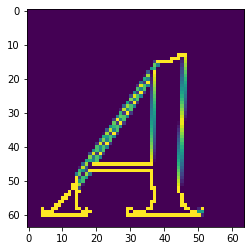

In [6]:
plt.imshow(np.array(data['rendered']).reshape(64, 64))

Подготовим даталоадеры.

In [7]:
data_train.loc[0, :]

uni                                                         97
width                                                      649
vwidth                                                    1000
sfd          SplineSet\n637 0 m 1,0,-1\n 595 0 l 1,1,-1\n 5...
id                                                           1
binary_fp                               12127215344058962203\n
Name: 0, dtype: object

In [78]:
class GlyphDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.map_class = {}
        self.cached = self.__getitem__(0)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        try:
            example = np.array(svg_utils._create_example(svg_utils._convert_to_path(self.df.loc[idx, :]))['rendered']
                              , dtype=np.float32)
            
            if not (self.df.loc[idx, "uni"] in self.map_class):
                len_ind = len(self.map_class)
                self.map_class[self.df.loc[idx, "uni"]] = len_ind
                
            return torch.FloatTensor(example.reshape(1, 64, 64)), self.map_class[self.df.loc[idx, "uni"]]
        except Exception as e:
            return self.cached

In [79]:
glyph_train = GlyphDataset(data_train)
glyph_test = GlyphDataset(data_test)

In [80]:
train_loader = DataLoader(glyph_train, batch_size=64)
for X_batch, Y_batch in train_loader:
    print(X_batch.size())
    print(Y_batch)
    break

torch.Size([64, 1, 64, 64])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61,  0,  1])


## Model declaration

In [11]:
%load_ext autoreload
%autoreload 2

In [84]:
config = ImageVAEConfig()

In [85]:
model = VAEModel(config)

In [86]:
from torchsummary import summary

summary(model, [(1, 64, 64), (1, 1, 1)])

tensor([[[[ 0.1975,  0.3291,  0.4104,  ...,  0.1341,  0.2541,  0.2247],
          [ 0.0897,  0.5155,  0.4756,  ...,  0.3540, -0.1822,  0.0089],
          [ 0.2443,  0.2290,  0.3401,  ...,  0.3207, -0.2052, -0.1620],
          ...,
          [ 0.1087,  0.0068,  0.4110,  ...,  0.2598,  0.4035,  0.2694],
          [ 0.0451,  0.4237,  0.1999,  ...,  0.2615,  0.1549,  0.1035],
          [ 0.0411, -0.0244,  0.0435,  ..., -0.0663,  0.0555,  0.0688]]],


        [[[ 0.3602,  0.3773,  0.2678,  ...,  0.1601,  0.3245,  0.2012],
          [ 0.0532,  0.4270,  0.2615,  ...,  0.2901, -0.1620,  0.1228],
          [ 0.0605,  0.3575,  0.5325,  ...,  0.0601, -0.1772,  0.0875],
          ...,
          [ 0.3049, -0.0225,  0.1514,  ...,  0.1026,  0.2966,  0.3306],
          [-0.0227,  0.3084,  0.0512,  ...,  0.2502,  0.0214,  0.2588],
          [ 0.1631,  0.1571,  0.0890,  ..., -0.0401,  0.0904,  0.0699]]]],
       grad_fn=<MkldnnConvolutionBackward>)
-------------------------------------------------------

## Training

In [87]:
opt = torch.optim.Adam(model.parameters(), eps=1e-6)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=4, min_lr=0.0001)

In [93]:
import time
from tqdm import tqdm


def train_model(model, opt, scheduler, train_loss, 
                val_accuracy, num_epochs, print_every=5):
    cur_max_acc = None
    for epoch in tqdm(range(num_epochs)):
        print(f'Start epoch {epoch}')
        start_time = time.time()
        model.train()
        epoch_loss = 0
        i = 0
        for X_batch, Y_batch in tqdm(train_loader):
            logits, losses = model(X_batch, Y_batch)
            #print(scores)
            #print(losses)
            loss = model.loss(logits, X_batch)[0]
            loss.backward()
            opt.step()
            opt.zero_grad()
            epoch_loss += loss.item()
            if i % print_every == 0:
                print(f'Epoch {epoch}, Batch {i}, loss {loss.item()}')
            i += 1
        cur_val_acc, cur_val_loss = get_accuracy(model, val_batch_gen)
        epoch_loss /= len(train_batch_gen)
        scheduler.step(cur_val_loss)
        
        train_loss.append(epoch_loss)
        val_accuracy.append(cur_val_acc)
        val_loss.append(cur_val_loss)
        
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print('  lr =', scheduler._last_lr[0])
        print("  training loss (in-iteration): \t{:.6f}".format(epoch_loss))
        print("  validate loss (in-iteration): \t{:.6f}".format(cur_val_loss))
        print("  validation accuracy: \t\t\t{:.2f} %".format(cur_val_acc * 100))
        if cur_max_acc is None or cur_val_acc > cur_max_acc:
            cur_max_acc = cur_val_acc
            torch.save(model.state_dict(), 'models/residual.best4')

In [ ]:
train_loss = []
val_accuracy = []
train_model(model, opt, scheduler, train_loss, val_accuracy, 3)

  0%|          | 0/30802 [00:00<?, ?it/s]

Start epoch 0



  0%|          | 1/30802 [00:04<40:21:40,  4.72s/it]

Epoch 0, Batch 0, loss 906986368.0



  0%|          | 6/30802 [00:29<42:14:42,  4.94s/it]

Epoch 0, Batch 5, loss 1040534464.0



  0%|          | 11/30802 [00:54<43:14:32,  5.06s/it]

Epoch 0, Batch 10, loss 593731456.0



  0%|          | 16/30802 [01:21<44:20:30,  5.19s/it]

Epoch 0, Batch 15, loss 1113464192.0



  0%|          | 21/30802 [01:46<43:30:33,  5.09s/it]

Epoch 0, Batch 20, loss 610878400.0



  0%|          | 26/30802 [02:13<47:02:27,  5.50s/it]

Epoch 0, Batch 25, loss 613307392.0



  0%|          | 31/30802 [02:39<44:42:49,  5.23s/it]

Epoch 0, Batch 30, loss 939639360.0



  0%|          | 36/30802 [03:03<41:36:44,  4.87s/it]

Epoch 0, Batch 35, loss 690484544.0



  0%|          | 41/30802 [03:29<44:39:25,  5.23s/it]

Epoch 0, Batch 40, loss 525598080.0



  0%|          | 46/30802 [03:54<43:02:26,  5.04s/it]

Epoch 0, Batch 45, loss 696640448.0



  0%|          | 51/30802 [04:20<44:30:35,  5.21s/it]

Epoch 0, Batch 50, loss 419475520.0



  0%|          | 56/30802 [04:47<46:14:30,  5.41s/it]

Epoch 0, Batch 55, loss 859417344.0



  0%|          | 61/30802 [05:13<44:06:52,  5.17s/it]

Epoch 0, Batch 60, loss 443934080.0



  0%|          | 66/30802 [05:39<45:30:30,  5.33s/it]

Epoch 0, Batch 65, loss 622865664.0



  0%|          | 71/30802 [06:04<43:20:45,  5.08s/it]

Epoch 0, Batch 70, loss 386213856.0



  0%|          | 76/30802 [06:30<43:58:36,  5.15s/it]

Epoch 0, Batch 75, loss 392070528.0



  0%|          | 81/30802 [06:58<47:09:33,  5.53s/it]

Epoch 0, Batch 80, loss 710798080.0



  0%|          | 86/30802 [07:24<46:36:13,  5.46s/it]

Epoch 0, Batch 85, loss 375969888.0



  0%|          | 91/30802 [07:50<44:14:42,  5.19s/it]

Epoch 0, Batch 90, loss 952713088.0



  0%|          | 96/30802 [08:16<44:10:48,  5.18s/it]

Epoch 0, Batch 95, loss 570656256.0



  0%|          | 101/30802 [08:42<45:09:45,  5.30s/it]

Epoch 0, Batch 100, loss 361456768.0



  0%|          | 106/30802 [09:07<43:30:55,  5.10s/it]

Epoch 0, Batch 105, loss 480790560.0



  0%|          | 111/30802 [09:33<43:58:52,  5.16s/it]

Epoch 0, Batch 110, loss 707270016.0



  0%|          | 116/30802 [09:58<43:10:41,  5.07s/it]

Epoch 0, Batch 115, loss 653032832.0



  0%|          | 121/30802 [10:24<43:46:23,  5.14s/it]

Epoch 0, Batch 120, loss 772333440.0



  0%|          | 126/30802 [10:49<42:59:32,  5.05s/it]

Epoch 0, Batch 125, loss 402995296.0



  0%|          | 131/30802 [11:16<44:16:05,  5.20s/it]

Epoch 0, Batch 130, loss 660794240.0



  0%|          | 136/30802 [11:44<47:36:26,  5.59s/it]

Epoch 0, Batch 135, loss 388058176.0



  0%|          | 141/30802 [12:10<44:14:41,  5.19s/it]

Epoch 0, Batch 140, loss 745089408.0



  0%|          | 146/30802 [12:36<43:57:57,  5.16s/it]

Epoch 0, Batch 145, loss 580981632.0



  0%|          | 151/30802 [13:02<44:19:34,  5.21s/it]

Epoch 0, Batch 150, loss 881145856.0



  1%|          | 156/30802 [13:29<45:52:03,  5.39s/it]

Epoch 0, Batch 155, loss 515270048.0



  1%|          | 161/30802 [13:56<46:18:28,  5.44s/it]

Epoch 0, Batch 160, loss 448900192.0



  1%|          | 166/30802 [14:21<44:03:33,  5.18s/it]

Epoch 0, Batch 165, loss 308787520.0



  1%|          | 171/30802 [14:48<45:30:50,  5.35s/it]

Epoch 0, Batch 170, loss 467368320.0



  1%|          | 176/30802 [15:15<45:45:43,  5.38s/it]

Epoch 0, Batch 175, loss 399273920.0



  1%|          | 181/30802 [15:40<43:36:20,  5.13s/it]

Epoch 0, Batch 180, loss 667990080.0



  1%|          | 186/30802 [16:07<44:27:52,  5.23s/it]

Epoch 0, Batch 185, loss 929094976.0



  1%|          | 191/30802 [16:33<45:00:37,  5.29s/it]

Epoch 0, Batch 190, loss 664767296.0



  1%|          | 196/30802 [16:59<43:46:20,  5.15s/it]

Epoch 0, Batch 195, loss 363640192.0



  1%|          | 201/30802 [17:24<43:56:16,  5.17s/it]

Epoch 0, Batch 200, loss 610595136.0



  1%|          | 206/30802 [17:52<45:26:15,  5.35s/it]

Epoch 0, Batch 205, loss 363528288.0



  1%|          | 211/30802 [18:18<45:27:56,  5.35s/it]

Epoch 0, Batch 210, loss 291391616.0



  1%|          | 216/30802 [18:46<46:26:29,  5.47s/it]

Epoch 0, Batch 215, loss 919080768.0



  1%|          | 221/30802 [19:13<45:53:11,  5.40s/it]

Epoch 0, Batch 220, loss 478903264.0



  1%|          | 226/30802 [19:40<46:41:47,  5.50s/it]

Epoch 0, Batch 225, loss 845928192.0



  1%|          | 231/30802 [20:07<46:11:25,  5.44s/it]

Epoch 0, Batch 230, loss 565408256.0



  1%|          | 236/30802 [20:34<45:00:07,  5.30s/it]

Epoch 0, Batch 235, loss 806827200.0



  1%|          | 241/30802 [21:01<45:33:35,  5.37s/it]

Epoch 0, Batch 240, loss 273589440.0



  1%|          | 246/30802 [21:28<45:05:39,  5.31s/it]

Epoch 0, Batch 245, loss 740802112.0



  1%|          | 251/30802 [21:55<45:05:00,  5.31s/it]

Epoch 0, Batch 250, loss 542894336.0



  1%|          | 256/30802 [22:21<44:34:50,  5.25s/it]

Epoch 0, Batch 255, loss 285418688.0



  1%|          | 261/30802 [22:47<44:22:20,  5.23s/it]

Epoch 0, Batch 260, loss 658497216.0



  1%|          | 266/30802 [23:15<46:01:32,  5.43s/it]

Epoch 0, Batch 265, loss 268013984.0



  1%|          | 271/30802 [23:41<44:09:36,  5.21s/it]

Epoch 0, Batch 270, loss 701073920.0



  1%|          | 276/30802 [24:08<45:41:48,  5.39s/it]

Epoch 0, Batch 275, loss 649189696.0



  1%|          | 281/30802 [24:34<43:44:59,  5.16s/it]

Epoch 0, Batch 280, loss 543145984.0



  1%|          | 286/30802 [25:00<44:22:44,  5.24s/it]

Epoch 0, Batch 285, loss 389396736.0



  1%|          | 291/30802 [25:26<44:03:37,  5.20s/it]

Epoch 0, Batch 290, loss 545387712.0



  1%|          | 296/30802 [25:53<44:23:59,  5.24s/it]

Epoch 0, Batch 295, loss 662233728.0



  1%|          | 301/30802 [26:18<43:40:08,  5.15s/it]

Epoch 0, Batch 300, loss 652254528.0



  1%|          | 306/30802 [26:46<46:15:24,  5.46s/it]

Epoch 0, Batch 305, loss 355545216.0



  1%|          | 311/30802 [27:12<45:30:53,  5.37s/it]

Epoch 0, Batch 310, loss 370339008.0



  1%|          | 316/30802 [27:38<44:02:10,  5.20s/it]

Epoch 0, Batch 315, loss 313193440.0



  1%|          | 321/30802 [28:04<44:05:09,  5.21s/it]

Epoch 0, Batch 320, loss 534350464.0



  1%|          | 326/30802 [28:30<44:31:08,  5.26s/it]

Epoch 0, Batch 325, loss 686888192.0



  1%|          | 331/30802 [28:57<45:03:32,  5.32s/it]

Epoch 0, Batch 330, loss 254935008.0



  1%|          | 336/30802 [29:23<44:09:19,  5.22s/it]

Epoch 0, Batch 335, loss 608006016.0



  1%|          | 341/30802 [29:50<44:49:09,  5.30s/it]

Epoch 0, Batch 340, loss 462432192.0



  1%|          | 346/30802 [30:17<46:14:46,  5.47s/it]

Epoch 0, Batch 345, loss 339304672.0



  1%|          | 351/30802 [30:44<44:48:51,  5.30s/it]

Epoch 0, Batch 350, loss 856408320.0



  1%|          | 356/30802 [31:10<45:03:44,  5.33s/it]

Epoch 0, Batch 355, loss 245379616.0



  1%|          | 361/30802 [31:37<45:13:08,  5.35s/it]

Epoch 0, Batch 360, loss 621125376.0



  1%|          | 366/30802 [32:04<45:36:40,  5.39s/it]

Epoch 0, Batch 365, loss 501030048.0



  1%|          | 371/30802 [32:31<44:35:05,  5.27s/it]

Epoch 0, Batch 370, loss 572023808.0



  1%|          | 376/30802 [32:58<45:35:00,  5.39s/it]

Epoch 0, Batch 375, loss 629134080.0



  1%|          | 381/30802 [33:23<43:14:36,  5.12s/it]

Epoch 0, Batch 380, loss 1119133312.0



  1%|▏         | 386/30802 [33:50<44:41:12,  5.29s/it]

Epoch 0, Batch 385, loss 580592000.0



  1%|▏         | 391/30802 [34:16<44:14:13,  5.24s/it]

Epoch 0, Batch 390, loss 520049280.0



  1%|▏         | 396/30802 [34:43<45:17:25,  5.36s/it]

Epoch 0, Batch 395, loss 395345408.0



  1%|▏         | 401/30802 [35:09<44:10:22,  5.23s/it]

Epoch 0, Batch 400, loss 685470208.0



  1%|▏         | 406/30802 [35:35<43:49:03,  5.19s/it]

Epoch 0, Batch 405, loss 571838912.0



  1%|▏         | 411/30802 [36:00<42:51:33,  5.08s/it]

Epoch 0, Batch 410, loss 627562560.0



  1%|▏         | 416/30802 [36:27<44:11:26,  5.24s/it]

Epoch 0, Batch 415, loss 664273664.0



  1%|▏         | 421/30802 [36:53<43:45:41,  5.19s/it]

Epoch 0, Batch 420, loss 525164544.0



  1%|▏         | 426/30802 [37:20<45:43:28,  5.42s/it]

Epoch 0, Batch 425, loss 424483904.0



  1%|▏         | 431/30802 [37:47<45:32:51,  5.40s/it]

Epoch 0, Batch 430, loss 363114400.0



  1%|▏         | 436/30802 [38:14<44:44:13,  5.30s/it]

Epoch 0, Batch 435, loss 504679008.0



  1%|▏         | 441/30802 [38:40<44:05:53,  5.23s/it]

Epoch 0, Batch 440, loss 616942656.0



  1%|▏         | 446/30802 [39:08<46:58:55,  5.57s/it]

Epoch 0, Batch 445, loss 285782912.0



  1%|▏         | 451/30802 [39:34<44:03:21,  5.23s/it]

Epoch 0, Batch 450, loss 557092544.0



  1%|▏         | 456/30802 [40:00<43:52:02,  5.20s/it]

Epoch 0, Batch 455, loss 242921856.0



  1%|▏         | 461/30802 [40:26<44:31:55,  5.28s/it]

Epoch 0, Batch 460, loss 239313248.0



  2%|▏         | 466/30802 [40:53<45:07:31,  5.36s/it]

Epoch 0, Batch 465, loss 620393344.0



  2%|▏         | 471/30802 [41:22<46:47:33,  5.55s/it]

Epoch 0, Batch 470, loss 458717216.0



  2%|▏         | 476/30802 [41:48<44:15:35,  5.25s/it]

Epoch 0, Batch 475, loss 430545248.0



  2%|▏         | 481/30802 [42:14<44:14:17,  5.25s/it]

Epoch 0, Batch 480, loss 418368352.0



  2%|▏         | 486/30802 [42:41<45:57:30,  5.46s/it]

Epoch 0, Batch 485, loss 261150528.0



  2%|▏         | 491/30802 [43:07<43:42:32,  5.19s/it]

Epoch 0, Batch 490, loss 258930336.0



  2%|▏         | 496/30802 [43:34<44:19:22,  5.27s/it]

Epoch 0, Batch 495, loss 219031648.0



  2%|▏         | 501/30802 [43:59<43:39:11,  5.19s/it]

Epoch 0, Batch 500, loss 571576768.0



  2%|▏         | 506/30802 [44:26<44:16:59,  5.26s/it]

Epoch 0, Batch 505, loss 629869440.0



  2%|▏         | 511/30802 [44:53<45:23:01,  5.39s/it]

Epoch 0, Batch 510, loss 477963648.0



  2%|▏         | 516/30802 [45:19<44:57:53,  5.34s/it]

Epoch 0, Batch 515, loss 730140544.0



  2%|▏         | 521/30802 [45:45<44:06:10,  5.24s/it]

Epoch 0, Batch 520, loss 349266080.0



  2%|▏         | 526/30802 [46:12<44:59:56,  5.35s/it]

Epoch 0, Batch 525, loss 658383552.0



  2%|▏         | 531/30802 [46:39<45:13:59,  5.38s/it]

Epoch 0, Batch 530, loss 245629408.0



  2%|▏         | 536/30802 [47:07<47:02:11,  5.59s/it]

Epoch 0, Batch 535, loss 204752576.0



  2%|▏         | 541/30802 [47:33<44:00:34,  5.24s/it]

Epoch 0, Batch 540, loss 512370592.0



  2%|▏         | 546/30802 [47:59<43:49:05,  5.21s/it]

Epoch 0, Batch 545, loss 521449536.0



  2%|▏         | 551/30802 [48:26<44:14:28,  5.26s/it]

Epoch 0, Batch 550, loss 501388544.0



  2%|▏         | 556/30802 [48:52<43:33:37,  5.18s/it]

Epoch 0, Batch 555, loss 404926816.0



  2%|▏         | 561/30802 [49:18<43:46:19,  5.21s/it]

Epoch 0, Batch 560, loss 397197216.0



  2%|▏         | 566/30802 [49:44<43:56:32,  5.23s/it]

Epoch 0, Batch 565, loss 604162496.0



  2%|▏         | 571/30802 [50:11<44:24:05,  5.29s/it]

Epoch 0, Batch 570, loss 434874432.0



  2%|▏         | 576/30802 [50:37<44:42:23,  5.32s/it]

Epoch 0, Batch 575, loss 216865424.0



  2%|▏         | 581/30802 [51:04<43:49:23,  5.22s/it]

Epoch 0, Batch 580, loss 313133088.0



  2%|▏         | 586/30802 [51:30<44:21:37,  5.29s/it]

Epoch 0, Batch 585, loss 410021760.0



  2%|▏         | 591/30802 [51:56<44:49:53,  5.34s/it]

Epoch 0, Batch 590, loss 681424256.0



  2%|▏         | 596/30802 [52:24<45:10:36,  5.38s/it]

Epoch 0, Batch 595, loss 149789888.0



  2%|▏         | 601/30802 [52:50<43:26:06,  5.18s/it]

Epoch 0, Batch 600, loss 586336832.0



  2%|▏         | 606/30802 [53:15<43:21:01,  5.17s/it]

Epoch 0, Batch 605, loss 450744288.0



  2%|▏         | 611/30802 [53:43<46:02:48,  5.49s/it]

Epoch 0, Batch 610, loss 405668256.0



  2%|▏         | 616/30802 [54:09<44:02:01,  5.25s/it]

Epoch 0, Batch 615, loss 465070048.0



  2%|▏         | 621/30802 [54:35<43:29:50,  5.19s/it]

Epoch 0, Batch 620, loss 230310656.0



  2%|▏         | 626/30802 [55:01<43:50:14,  5.23s/it]

Epoch 0, Batch 625, loss 573032384.0



  2%|▏         | 631/30802 [55:28<44:35:31,  5.32s/it]

Epoch 0, Batch 630, loss 588564224.0



  2%|▏         | 636/30802 [55:54<43:58:49,  5.25s/it]

Epoch 0, Batch 635, loss 579667584.0



  2%|▏         | 641/30802 [56:21<45:15:32,  5.40s/it]

Epoch 0, Batch 640, loss 305237792.0



  2%|▏         | 646/30802 [56:47<45:05:51,  5.38s/it]

Epoch 0, Batch 645, loss 644057728.0



  2%|▏         | 651/30802 [57:13<43:25:38,  5.19s/it]

Epoch 0, Batch 650, loss 690283712.0



  2%|▏         | 656/30802 [57:39<44:27:54,  5.31s/it]

Epoch 0, Batch 655, loss 683444928.0



  2%|▏         | 661/30802 [58:06<44:20:53,  5.30s/it]

Epoch 0, Batch 660, loss 593033280.0



  2%|▏         | 666/30802 [58:32<44:02:47,  5.26s/it]

Epoch 0, Batch 665, loss 610257792.0



  2%|▏         | 671/30802 [59:02<51:10:09,  6.11s/it]

Epoch 0, Batch 670, loss 609869760.0



  2%|▏         | 676/30802 [59:34<53:55:51,  6.44s/it]

Epoch 0, Batch 675, loss 641147456.0



  2%|▏         | 681/30802 [1:00:07<53:20:04,  6.37s/it]

Epoch 0, Batch 680, loss 363055840.0



  2%|▏         | 686/30802 [1:00:39<54:16:02,  6.49s/it]

Epoch 0, Batch 685, loss 494661376.0



  2%|▏         | 691/30802 [1:01:12<53:19:42,  6.38s/it]

Epoch 0, Batch 690, loss 642024832.0



  2%|▏         | 696/30802 [1:01:42<49:21:34,  5.90s/it]

Epoch 0, Batch 695, loss 110278752.0



  2%|▏         | 701/30802 [1:02:09<44:35:42,  5.33s/it]

Epoch 0, Batch 700, loss 554037952.0



  2%|▏         | 706/30802 [1:02:35<43:53:55,  5.25s/it]

Epoch 0, Batch 705, loss 624094080.0



  2%|▏         | 711/30802 [1:03:02<44:42:35,  5.35s/it]

Epoch 0, Batch 710, loss 312063136.0



  2%|▏         | 716/30802 [1:03:28<44:03:00,  5.27s/it]

Epoch 0, Batch 715, loss 408466432.0



  2%|▏         | 721/30802 [1:03:54<43:08:43,  5.16s/it]

Epoch 0, Batch 720, loss 396039648.0



  2%|▏         | 726/30802 [1:04:23<47:33:49,  5.69s/it]

Epoch 0, Batch 725, loss 936625024.0



  2%|▏         | 731/30802 [1:04:50<45:15:51,  5.42s/it]

Epoch 0, Batch 730, loss 573741632.0



  2%|▏         | 736/30802 [1:05:18<47:07:50,  5.64s/it]

Epoch 0, Batch 735, loss 53728992.0



  2%|▏         | 741/30802 [1:05:43<43:13:42,  5.18s/it]

Epoch 0, Batch 740, loss 856541056.0



  2%|▏         | 746/30802 [1:06:09<43:16:22,  5.18s/it]

Epoch 0, Batch 745, loss 429081920.0



  2%|▏         | 751/30802 [1:06:36<44:50:33,  5.37s/it]

Epoch 0, Batch 750, loss 356937184.0



  2%|▏         | 756/30802 [1:07:02<43:30:48,  5.21s/it]

Epoch 0, Batch 755, loss 494516640.0



  2%|▏         | 761/30802 [1:07:28<44:05:02,  5.28s/it]

Epoch 0, Batch 760, loss 502547648.0



  2%|▏         | 766/30802 [1:07:56<45:55:48,  5.51s/it]

Epoch 0, Batch 765, loss 690652928.0



  3%|▎         | 771/30802 [1:08:23<44:52:05,  5.38s/it]

Epoch 0, Batch 770, loss 714929664.0



  3%|▎         | 776/30802 [1:08:50<44:24:28,  5.32s/it]

Epoch 0, Batch 775, loss 648113792.0



  3%|▎         | 781/30802 [1:09:18<48:58:57,  5.87s/it]

Epoch 0, Batch 780, loss 609817792.0



  3%|▎         | 786/30802 [1:09:50<51:00:42,  6.12s/it]

Epoch 0, Batch 785, loss 519039968.0



  3%|▎         | 791/30802 [1:10:22<53:06:20,  6.37s/it]

Epoch 0, Batch 790, loss 459204992.0



  3%|▎         | 796/30802 [1:10:54<54:31:22,  6.54s/it]

Epoch 0, Batch 795, loss 381028864.0



  3%|▎         | 801/30802 [1:11:28<56:24:19,  6.77s/it]

Epoch 0, Batch 800, loss 96536576.0



  3%|▎         | 806/30802 [1:12:02<56:30:08,  6.78s/it]

Epoch 0, Batch 805, loss 429444992.0



  3%|▎         | 811/30802 [1:12:35<55:53:57,  6.71s/it]

Epoch 0, Batch 810, loss 125569760.0



  3%|▎         | 816/30802 [1:13:09<55:57:54,  6.72s/it]

Epoch 0, Batch 815, loss 420485664.0



  3%|▎         | 821/30802 [1:13:42<56:18:05,  6.76s/it]

Epoch 0, Batch 820, loss 743937152.0



  3%|▎         | 826/30802 [1:14:17<57:03:10,  6.85s/it]

Epoch 0, Batch 825, loss 529878784.0



  3%|▎         | 831/30802 [1:14:51<57:47:32,  6.94s/it]

Epoch 0, Batch 830, loss 126969856.0



  3%|▎         | 836/30802 [1:15:23<55:17:34,  6.64s/it]

Epoch 0, Batch 835, loss 649710720.0



  3%|▎         | 841/30802 [1:15:55<54:14:33,  6.52s/it]

Epoch 0, Batch 840, loss 717655296.0



  3%|▎         | 846/30802 [1:16:29<56:19:10,  6.77s/it]

Epoch 0, Batch 845, loss 163870096.0



  3%|▎         | 851/30802 [1:17:03<56:23:56,  6.78s/it]

Epoch 0, Batch 850, loss 614467584.0



  3%|▎         | 856/30802 [1:17:36<56:51:29,  6.84s/it]

Epoch 0, Batch 855, loss 196083904.0



  3%|▎         | 861/30802 [1:18:09<55:12:03,  6.64s/it]

Epoch 0, Batch 860, loss 390890464.0



  3%|▎         | 866/30802 [1:18:44<58:12:56,  7.00s/it]

Epoch 0, Batch 865, loss 351156192.0



  3%|▎         | 871/30802 [1:19:17<55:12:48,  6.64s/it]

Epoch 0, Batch 870, loss 673037760.0



  3%|▎         | 876/30802 [1:19:51<57:00:03,  6.86s/it]

Epoch 0, Batch 875, loss 227176272.0



  3%|▎         | 881/30802 [1:20:26<57:58:49,  6.98s/it]

Epoch 0, Batch 880, loss 162949104.0



  3%|▎         | 886/30802 [1:20:59<54:38:03,  6.57s/it]

Epoch 0, Batch 885, loss 589083392.0



  3%|▎         | 891/30802 [1:21:32<55:41:29,  6.70s/it]

Epoch 0, Batch 890, loss 90425320.0



  3%|▎         | 896/30802 [1:22:05<55:02:20,  6.63s/it]

Epoch 0, Batch 895, loss 552265344.0



  3%|▎         | 901/30802 [1:22:38<54:01:34,  6.50s/it]

Epoch 0, Batch 900, loss 584995904.0



  3%|▎         | 906/30802 [1:23:11<55:18:40,  6.66s/it]

Epoch 0, Batch 905, loss 649878144.0



  3%|▎         | 911/30802 [1:23:44<54:54:34,  6.61s/it]

Epoch 0, Batch 910, loss 581576704.0



  3%|▎         | 916/30802 [1:24:17<55:17:36,  6.66s/it]

Epoch 0, Batch 915, loss 326670592.0



  3%|▎         | 921/30802 [1:24:49<53:14:27,  6.41s/it]

Epoch 0, Batch 920, loss 594078208.0



  3%|▎         | 926/30802 [1:25:21<53:26:20,  6.44s/it]

Epoch 0, Batch 925, loss 183043472.0



  3%|▎         | 931/30802 [1:25:55<54:34:47,  6.58s/it]

Epoch 0, Batch 930, loss 671747008.0



  3%|▎         | 936/30802 [1:26:28<55:08:04,  6.65s/it]

Epoch 0, Batch 935, loss 533680512.0



  3%|▎         | 941/30802 [1:27:02<56:29:08,  6.81s/it]

Epoch 0, Batch 940, loss 524352384.0



  3%|▎         | 946/30802 [1:27:35<56:09:53,  6.77s/it]

Epoch 0, Batch 945, loss 38164740.0



  3%|▎         | 951/30802 [1:28:08<54:17:58,  6.55s/it]

Epoch 0, Batch 950, loss 421185792.0



  3%|▎         | 956/30802 [1:28:42<56:17:40,  6.79s/it]

Epoch 0, Batch 955, loss 504331456.0



  3%|▎         | 961/30802 [1:29:15<55:31:26,  6.70s/it]

Epoch 0, Batch 960, loss 205563488.0



  3%|▎         | 966/30802 [1:29:48<53:05:07,  6.41s/it]

Epoch 0, Batch 965, loss 396521024.0



  3%|▎         | 971/30802 [1:30:15<46:13:00,  5.58s/it]

Epoch 0, Batch 970, loss 513130720.0



  3%|▎         | 976/30802 [1:30:45<51:22:25,  6.20s/it]

Epoch 0, Batch 975, loss 69475504.0



  3%|▎         | 981/30802 [1:31:18<53:54:25,  6.51s/it]

Epoch 0, Batch 980, loss 439004416.0



  3%|▎         | 986/30802 [1:31:50<53:30:03,  6.46s/it]

Epoch 0, Batch 985, loss 305488448.0



  3%|▎         | 991/30802 [1:32:23<55:31:36,  6.71s/it]

Epoch 0, Batch 990, loss 122754976.0



  3%|▎         | 996/30802 [1:32:51<46:38:05,  5.63s/it]

Epoch 0, Batch 995, loss 136344528.0



  3%|▎         | 1001/30802 [1:33:17<43:38:39,  5.27s/it]

Epoch 0, Batch 1000, loss 660655552.0



  3%|▎         | 1006/30802 [1:33:45<46:43:25,  5.65s/it]

Epoch 0, Batch 1005, loss 292087648.0



  3%|▎         | 1011/30802 [1:34:12<44:33:55,  5.39s/it]

Epoch 0, Batch 1010, loss 699850048.0



  3%|▎         | 1016/30802 [1:34:38<42:18:32,  5.11s/it]

Epoch 0, Batch 1015, loss 297631424.0



  3%|▎         | 1021/30802 [1:35:04<43:51:03,  5.30s/it]

Epoch 0, Batch 1020, loss 70375664.0



  3%|▎         | 1026/30802 [1:35:30<42:45:41,  5.17s/it]

Epoch 0, Batch 1025, loss 472614048.0



  3%|▎         | 1031/30802 [1:35:56<43:18:37,  5.24s/it]

Epoch 0, Batch 1030, loss 104534480.0



  3%|▎         | 1036/30802 [1:36:21<41:58:09,  5.08s/it]

Epoch 0, Batch 1035, loss 396227584.0



  3%|▎         | 1041/30802 [1:36:47<42:35:11,  5.15s/it]

Epoch 0, Batch 1040, loss 396707168.0



  3%|▎         | 1046/30802 [1:37:19<51:04:14,  6.18s/it]

Epoch 0, Batch 1045, loss 290548896.0



  3%|▎         | 1051/30802 [1:37:51<52:12:34,  6.32s/it]

Epoch 0, Batch 1050, loss 194119760.0



  3%|▎         | 1056/30802 [1:38:25<55:34:02,  6.73s/it]

Epoch 0, Batch 1055, loss 648126784.0



  3%|▎         | 1061/30802 [1:38:59<55:33:24,  6.72s/it]

Epoch 0, Batch 1060, loss 285915200.0



  3%|▎         | 1066/30802 [1:39:32<54:57:58,  6.65s/it]

Epoch 0, Batch 1065, loss 233514496.0



  3%|▎         | 1071/30802 [1:40:04<52:50:54,  6.40s/it]

Epoch 0, Batch 1070, loss 687816768.0



  3%|▎         | 1076/30802 [1:40:36<53:53:02,  6.53s/it]

Epoch 0, Batch 1075, loss 33466788.0



  4%|▎         | 1081/30802 [1:41:08<52:48:24,  6.40s/it]

Epoch 0, Batch 1080, loss 492297056.0



  4%|▎         | 1086/30802 [1:41:41<53:29:43,  6.48s/it]

Epoch 0, Batch 1085, loss 520010656.0



  4%|▎         | 1091/30802 [1:42:14<54:07:46,  6.56s/it]

Epoch 0, Batch 1090, loss 607415680.0



  4%|▎         | 1096/30802 [1:42:46<52:30:05,  6.36s/it]

Epoch 0, Batch 1095, loss 455145728.0



  4%|▎         | 1101/30802 [1:43:19<55:03:28,  6.67s/it]

Epoch 0, Batch 1100, loss 315406144.0



  4%|▎         | 1106/30802 [1:43:53<54:54:23,  6.66s/it]

Epoch 0, Batch 1105, loss 631123840.0



  4%|▎         | 1111/30802 [1:44:25<54:45:48,  6.64s/it]

Epoch 0, Batch 1110, loss 404383296.0



  4%|▎         | 1116/30802 [1:44:58<54:10:10,  6.57s/it]

Epoch 0, Batch 1115, loss 485156384.0



  4%|▎         | 1121/30802 [1:45:32<56:10:19,  6.81s/it]

Epoch 0, Batch 1120, loss 67308264.0



  4%|▎         | 1126/30802 [1:46:06<56:17:15,  6.83s/it]

Epoch 0, Batch 1125, loss 322016736.0



  4%|▎         | 1131/30802 [1:46:39<55:38:19,  6.75s/it]

Epoch 0, Batch 1130, loss 171268416.0



  4%|▎         | 1136/30802 [1:47:12<54:44:16,  6.64s/it]

Epoch 0, Batch 1135, loss 745912576.0



  4%|▎         | 1141/30802 [1:47:45<53:36:50,  6.51s/it]

Epoch 0, Batch 1140, loss 347901856.0



  4%|▎         | 1146/30802 [1:48:18<54:35:08,  6.63s/it]

Epoch 0, Batch 1145, loss 653103424.0



  4%|▎         | 1151/30802 [1:48:53<56:25:41,  6.85s/it]

Epoch 0, Batch 1150, loss 139735136.0



  4%|▍         | 1156/30802 [1:49:25<52:39:48,  6.40s/it]

Epoch 0, Batch 1155, loss 828244992.0



  4%|▍         | 1161/30802 [1:49:57<53:43:30,  6.53s/it]

Epoch 0, Batch 1160, loss 359498624.0



  4%|▍         | 1166/30802 [1:50:29<52:51:53,  6.42s/it]

Epoch 0, Batch 1165, loss 444566240.0



  4%|▍         | 1171/30802 [1:51:01<52:48:18,  6.42s/it]

Epoch 0, Batch 1170, loss 501938816.0



  4%|▍         | 1176/30802 [1:51:35<55:48:39,  6.78s/it]

Epoch 0, Batch 1175, loss 758049408.0



  4%|▍         | 1181/30802 [1:52:07<53:08:42,  6.46s/it]

Epoch 0, Batch 1180, loss 538199616.0



  4%|▍         | 1186/30802 [1:52:39<53:15:33,  6.47s/it]

Epoch 0, Batch 1185, loss 563362368.0



  4%|▍         | 1191/30802 [1:53:12<52:15:00,  6.35s/it]

Epoch 0, Batch 1190, loss 523982528.0



  4%|▍         | 1196/30802 [1:53:44<52:45:18,  6.41s/it]

Epoch 0, Batch 1195, loss 592658880.0



  4%|▍         | 1201/30802 [1:54:17<52:48:06,  6.42s/it]

Epoch 0, Batch 1200, loss 634877376.0



  4%|▍         | 1206/30802 [1:54:49<52:48:46,  6.42s/it]

Epoch 0, Batch 1205, loss 169396464.0



  4%|▍         | 1211/30802 [1:55:21<52:46:10,  6.42s/it]

Epoch 0, Batch 1210, loss 70683368.0



  4%|▍         | 1216/30802 [1:55:52<51:32:14,  6.27s/it]

Epoch 0, Batch 1215, loss 177281056.0



  4%|▍         | 1221/30802 [1:56:24<51:52:47,  6.31s/it]

Epoch 0, Batch 1220, loss 466279616.0



  4%|▍         | 1226/30802 [1:56:59<56:21:35,  6.86s/it]

Epoch 0, Batch 1225, loss 583917056.0



  4%|▍         | 1231/30802 [1:57:32<54:41:57,  6.66s/it]

Epoch 0, Batch 1230, loss 434527520.0



  4%|▍         | 1236/30802 [1:58:05<54:16:02,  6.61s/it]

Epoch 0, Batch 1235, loss 676486912.0



  4%|▍         | 1241/30802 [1:58:38<54:02:04,  6.58s/it]

Epoch 0, Batch 1240, loss 419888096.0



  4%|▍         | 1246/30802 [1:59:10<53:19:50,  6.50s/it]

Epoch 0, Batch 1245, loss 447891360.0



  4%|▍         | 1251/30802 [1:59:43<53:01:18,  6.46s/it]

Epoch 0, Batch 1250, loss 644655360.0



  4%|▍         | 1256/30802 [2:00:16<53:09:51,  6.48s/it]

Epoch 0, Batch 1255, loss 619577088.0



  4%|▍         | 1261/30802 [2:00:48<53:02:36,  6.46s/it]

Epoch 0, Batch 1260, loss 414728896.0



  4%|▍         | 1266/30802 [2:01:19<51:57:39,  6.33s/it]

Epoch 0, Batch 1265, loss 732366784.0



  4%|▍         | 1271/30802 [2:01:51<52:10:45,  6.36s/it]

Epoch 0, Batch 1270, loss 339411840.0



  4%|▍         | 1276/30802 [2:02:22<51:02:00,  6.22s/it]

Epoch 0, Batch 1275, loss 486490112.0



  4%|▍         | 1281/30802 [2:02:52<47:59:11,  5.85s/it]

Epoch 0, Batch 1280, loss 538658880.0



  4%|▍         | 1286/30802 [2:03:18<42:40:31,  5.21s/it]

Epoch 0, Batch 1285, loss 565794176.0



  4%|▍         | 1291/30802 [2:03:45<43:56:15,  5.36s/it]

Epoch 0, Batch 1290, loss 452766944.0



  4%|▍         | 1296/30802 [2:04:10<42:26:33,  5.18s/it]

Epoch 0, Batch 1295, loss 360499648.0



  4%|▍         | 1301/30802 [2:04:36<42:18:42,  5.16s/it]

Epoch 0, Batch 1300, loss 463301344.0



  4%|▍         | 1306/30802 [2:05:03<44:22:43,  5.42s/it]

Epoch 0, Batch 1305, loss 110985936.0



  4%|▍         | 1311/30802 [2:05:31<45:14:56,  5.52s/it]

Epoch 0, Batch 1310, loss 406104576.0



  4%|▍         | 1316/30802 [2:05:56<42:09:29,  5.15s/it]

Epoch 0, Batch 1315, loss 512982624.0



  4%|▍         | 1321/30802 [2:06:22<42:08:50,  5.15s/it]

Epoch 0, Batch 1320, loss 60619104.0



  4%|▍         | 1326/30802 [2:06:49<44:27:55,  5.43s/it]

Epoch 0, Batch 1325, loss 52656004.0



  4%|▍         | 1331/30802 [2:07:15<42:46:41,  5.23s/it]

Epoch 0, Batch 1330, loss 253441088.0



  4%|▍         | 1336/30802 [2:07:41<42:41:13,  5.22s/it]

Epoch 0, Batch 1335, loss 661810176.0



  4%|▍         | 1341/30802 [2:08:07<42:05:08,  5.14s/it]

Epoch 0, Batch 1340, loss 656622208.0



  4%|▍         | 1346/30802 [2:08:33<43:25:02,  5.31s/it]

Epoch 0, Batch 1345, loss 61799636.0



  4%|▍         | 1351/30802 [2:09:01<44:36:21,  5.45s/it]

Epoch 0, Batch 1350, loss 100483248.0



  4%|▍         | 1356/30802 [2:09:26<42:17:56,  5.17s/it]

Epoch 0, Batch 1355, loss 343317888.0



  4%|▍         | 1361/30802 [2:09:53<42:55:23,  5.25s/it]

Epoch 0, Batch 1360, loss 352573536.0



  4%|▍         | 1366/30802 [2:10:19<43:37:21,  5.34s/it]

Epoch 0, Batch 1365, loss 190078944.0



  4%|▍         | 1371/30802 [2:10:47<44:16:15,  5.42s/it]

Epoch 0, Batch 1370, loss 378673152.0



  4%|▍         | 1376/30802 [2:11:13<42:24:27,  5.19s/it]

Epoch 0, Batch 1375, loss 95165792.0



  4%|▍         | 1381/30802 [2:11:40<44:06:59,  5.40s/it]

Epoch 0, Batch 1380, loss 98458624.0



  4%|▍         | 1386/30802 [2:12:06<43:13:27,  5.29s/it]

Epoch 0, Batch 1385, loss 350043968.0



  5%|▍         | 1391/30802 [2:12:32<42:26:00,  5.19s/it]

Epoch 0, Batch 1390, loss 59264604.0



  5%|▍         | 1396/30802 [2:12:58<42:31:34,  5.21s/it]

Epoch 0, Batch 1395, loss 345506496.0



  5%|▍         | 1401/30802 [2:13:25<43:49:32,  5.37s/it]

Epoch 0, Batch 1400, loss 152195648.0



  5%|▍         | 1406/30802 [2:13:52<43:49:38,  5.37s/it]

Epoch 0, Batch 1405, loss 203310240.0



  5%|▍         | 1411/30802 [2:14:17<41:32:28,  5.09s/it]

Epoch 0, Batch 1410, loss 60799404.0



  5%|▍         | 1416/30802 [2:14:43<42:54:31,  5.26s/it]

Epoch 0, Batch 1415, loss 642581696.0



  5%|▍         | 1421/30802 [2:15:09<42:14:45,  5.18s/it]

Epoch 0, Batch 1420, loss 239298544.0



  5%|▍         | 1426/30802 [2:15:35<41:34:04,  5.09s/it]

Epoch 0, Batch 1425, loss 523718528.0



  5%|▍         | 1431/30802 [2:16:00<42:04:48,  5.16s/it]

Epoch 0, Batch 1430, loss 426015232.0



  5%|▍         | 1436/30802 [2:16:27<42:55:21,  5.26s/it]

Epoch 0, Batch 1435, loss 241327088.0



  5%|▍         | 1441/30802 [2:16:54<42:30:08,  5.21s/it]

Epoch 0, Batch 1440, loss 503579264.0



  5%|▍         | 1446/30802 [2:17:19<42:01:30,  5.15s/it]

Epoch 0, Batch 1445, loss 419842400.0



  5%|▍         | 1451/30802 [2:17:45<42:10:18,  5.17s/it]

Epoch 0, Batch 1450, loss 667380416.0



  5%|▍         | 1456/30802 [2:18:12<42:42:25,  5.24s/it]

Epoch 0, Batch 1455, loss 331561728.0



  5%|▍         | 1461/30802 [2:18:38<42:48:58,  5.25s/it]

Epoch 0, Batch 1460, loss 115213808.0



  5%|▍         | 1466/30802 [2:19:04<42:52:31,  5.26s/it]

Epoch 0, Batch 1465, loss 449802848.0



  5%|▍         | 1471/30802 [2:19:30<42:52:43,  5.26s/it]

Epoch 0, Batch 1470, loss 383792224.0



  5%|▍         | 1476/30802 [2:19:56<41:42:43,  5.12s/it]

Epoch 0, Batch 1475, loss 927951872.0



  5%|▍         | 1481/30802 [2:20:22<42:55:03,  5.27s/it]

Epoch 0, Batch 1480, loss 487029536.0



  5%|▍         | 1486/30802 [2:20:49<43:19:47,  5.32s/it]

Epoch 0, Batch 1485, loss 197212960.0



  5%|▍         | 1491/30802 [2:21:15<42:46:07,  5.25s/it]

Epoch 0, Batch 1490, loss 317140768.0



  5%|▍         | 1496/30802 [2:21:40<42:06:41,  5.17s/it]

Epoch 0, Batch 1495, loss 308957024.0



  5%|▍         | 1501/30802 [2:22:07<43:19:10,  5.32s/it]

Epoch 0, Batch 1500, loss 518453472.0



  5%|▍         | 1506/30802 [2:22:33<41:32:15,  5.10s/it]

Epoch 0, Batch 1505, loss 526361472.0



  5%|▍         | 1511/30802 [2:22:58<42:01:17,  5.16s/it]

Epoch 0, Batch 1510, loss 573753984.0



  5%|▍         | 1516/30802 [2:23:25<42:45:34,  5.26s/it]

Epoch 0, Batch 1515, loss 504025440.0



  5%|▍         | 1521/30802 [2:23:53<45:44:29,  5.62s/it]

Epoch 0, Batch 1520, loss 64874324.0



  5%|▍         | 1526/30802 [2:24:19<41:57:14,  5.16s/it]

Epoch 0, Batch 1525, loss 396800320.0



  5%|▍         | 1531/30802 [2:24:45<42:25:16,  5.22s/it]

Epoch 0, Batch 1530, loss 411328960.0



  5%|▍         | 1536/30802 [2:25:12<43:10:12,  5.31s/it]

Epoch 0, Batch 1535, loss 469853984.0



  5%|▌         | 1541/30802 [2:25:37<41:25:44,  5.10s/it]

Epoch 0, Batch 1540, loss 375099840.0



  5%|▌         | 1546/30802 [2:26:03<41:59:47,  5.17s/it]

Epoch 0, Batch 1545, loss 863983296.0



  5%|▌         | 1551/30802 [2:26:29<42:25:26,  5.22s/it]

Epoch 0, Batch 1550, loss 63410608.0



  5%|▌         | 1556/30802 [2:26:55<41:43:47,  5.14s/it]

Epoch 0, Batch 1555, loss 66580724.0



  5%|▌         | 1561/30802 [2:27:22<42:36:46,  5.25s/it]

Epoch 0, Batch 1560, loss 405943072.0



  5%|▌         | 1566/30802 [2:27:49<43:41:30,  5.38s/it]

Epoch 0, Batch 1565, loss 58103504.0



  5%|▌         | 1571/30802 [2:28:15<42:49:08,  5.27s/it]

Epoch 0, Batch 1570, loss 143490976.0



  5%|▌         | 1576/30802 [2:28:41<42:15:58,  5.21s/it]

Epoch 0, Batch 1575, loss 1116161792.0



  5%|▌         | 1581/30802 [2:29:07<42:15:37,  5.21s/it]

Epoch 0, Batch 1580, loss 531353856.0



  5%|▌         | 1586/30802 [2:29:34<43:08:03,  5.32s/it]

Epoch 0, Batch 1585, loss 276685376.0



  5%|▌         | 1591/30802 [2:30:02<45:21:10,  5.59s/it]

Epoch 0, Batch 1590, loss 256174624.0



  5%|▌         | 1596/30802 [2:30:29<43:35:27,  5.37s/it]

Epoch 0, Batch 1595, loss 426925088.0



  5%|▌         | 1601/30802 [2:30:55<42:00:53,  5.18s/it]

Epoch 0, Batch 1600, loss 57044508.0



  5%|▌         | 1606/30802 [2:31:21<41:39:36,  5.14s/it]

Epoch 0, Batch 1605, loss 423814560.0



  5%|▌         | 1611/30802 [2:31:47<42:29:55,  5.24s/it]

Epoch 0, Batch 1610, loss 465563264.0



  5%|▌         | 1616/30802 [2:32:13<42:29:15,  5.24s/it]

Epoch 0, Batch 1615, loss 539420032.0



  5%|▌         | 1621/30802 [2:32:39<42:19:49,  5.22s/it]

Epoch 0, Batch 1620, loss 263168160.0



  5%|▌         | 1626/30802 [2:33:06<42:15:36,  5.21s/it]

Epoch 0, Batch 1625, loss 465893376.0



  5%|▌         | 1631/30802 [2:33:32<42:54:18,  5.29s/it]

Epoch 0, Batch 1630, loss 443388192.0



  5%|▌         | 1636/30802 [2:33:58<41:58:09,  5.18s/it]

Epoch 0, Batch 1635, loss 289217344.0



  5%|▌         | 1641/30802 [2:34:26<44:06:36,  5.45s/it]

Epoch 0, Batch 1640, loss 454059648.0



  5%|▌         | 1646/30802 [2:34:52<42:24:38,  5.24s/it]

Epoch 0, Batch 1645, loss 348586848.0



  5%|▌         | 1651/30802 [2:35:18<42:15:25,  5.22s/it]

Epoch 0, Batch 1650, loss 126955736.0



  5%|▌         | 1656/30802 [2:35:45<42:51:39,  5.29s/it]

Epoch 0, Batch 1655, loss 312730592.0



  5%|▌         | 1661/30802 [2:36:11<42:51:43,  5.30s/it]

Epoch 0, Batch 1660, loss 103400600.0



  5%|▌         | 1666/30802 [2:36:37<41:54:10,  5.18s/it]

Epoch 0, Batch 1665, loss 277815072.0



  5%|▌         | 1671/30802 [2:37:03<42:54:29,  5.30s/it]

Epoch 0, Batch 1670, loss 214841088.0



  5%|▌         | 1676/30802 [2:37:29<41:50:52,  5.17s/it]

Epoch 0, Batch 1675, loss 881374720.0



  5%|▌         | 1681/30802 [2:37:55<41:39:44,  5.15s/it]

Epoch 0, Batch 1680, loss 423233696.0



  5%|▌         | 1686/30802 [2:38:21<42:26:48,  5.25s/it]

Epoch 0, Batch 1685, loss 598764288.0



  5%|▌         | 1691/30802 [2:38:47<41:50:53,  5.18s/it]

Epoch 0, Batch 1690, loss 353523072.0



  6%|▌         | 1696/30802 [2:39:13<41:17:56,  5.11s/it]

Epoch 0, Batch 1695, loss 211169440.0



  6%|▌         | 1701/30802 [2:39:40<43:15:07,  5.35s/it]

Epoch 0, Batch 1700, loss 229057952.0



  6%|▌         | 1706/30802 [2:40:07<43:29:45,  5.38s/it]

Epoch 0, Batch 1705, loss 516733984.0



  6%|▌         | 1711/30802 [2:40:34<42:44:55,  5.29s/it]

Epoch 0, Batch 1710, loss 524462784.0



  6%|▌         | 1716/30802 [2:41:00<42:16:37,  5.23s/it]

Epoch 0, Batch 1715, loss 530197408.0



  6%|▌         | 1721/30802 [2:41:26<43:20:40,  5.37s/it]

Epoch 0, Batch 1720, loss 120059312.0



  6%|▌         | 1726/30802 [2:41:53<42:43:29,  5.29s/it]

Epoch 0, Batch 1725, loss 535359040.0



  6%|▌         | 1731/30802 [2:42:18<40:57:09,  5.07s/it]

Epoch 0, Batch 1730, loss 423791008.0



  6%|▌         | 1736/30802 [2:42:45<43:13:14,  5.35s/it]

Epoch 0, Batch 1735, loss 258064384.0



  6%|▌         | 1741/30802 [2:43:11<42:46:40,  5.30s/it]

Epoch 0, Batch 1740, loss 391430944.0



  6%|▌         | 1746/30802 [2:43:37<42:01:07,  5.21s/it]

Epoch 0, Batch 1745, loss 593519360.0



  6%|▌         | 1751/30802 [2:44:03<41:16:39,  5.12s/it]

Epoch 0, Batch 1750, loss 154025152.0



  6%|▌         | 1756/30802 [2:44:29<42:10:48,  5.23s/it]

Epoch 0, Batch 1755, loss 111579576.0



  6%|▌         | 1761/30802 [2:44:55<42:12:21,  5.23s/it]

Epoch 0, Batch 1760, loss 52302684.0



  6%|▌         | 1766/30802 [2:45:22<42:14:21,  5.24s/it]

Epoch 0, Batch 1765, loss 454458400.0



  6%|▌         | 1771/30802 [2:45:48<42:17:14,  5.24s/it]

Epoch 0, Batch 1770, loss 603722624.0



  6%|▌         | 1776/30802 [2:46:14<41:38:51,  5.17s/it]

Epoch 0, Batch 1775, loss 515263040.0



  6%|▌         | 1781/30802 [2:46:40<42:21:27,  5.25s/it]

Epoch 0, Batch 1780, loss 449580608.0



  6%|▌         | 1786/30802 [2:47:07<42:57:08,  5.33s/it]

Epoch 0, Batch 1785, loss 365591008.0



  6%|▌         | 1791/30802 [2:47:33<42:16:57,  5.25s/it]

Epoch 0, Batch 1790, loss 509118464.0



  6%|▌         | 1796/30802 [2:47:59<41:36:36,  5.16s/it]

Epoch 0, Batch 1795, loss 525579680.0



  6%|▌         | 1801/30802 [2:48:25<41:46:30,  5.19s/it]

Epoch 0, Batch 1800, loss 374899680.0



  6%|▌         | 1806/30802 [2:48:50<41:54:30,  5.20s/it]

Epoch 0, Batch 1805, loss 605420032.0



  6%|▌         | 1811/30802 [2:49:18<44:33:22,  5.53s/it]

Epoch 0, Batch 1810, loss 326284064.0



  6%|▌         | 1816/30802 [2:49:44<41:32:41,  5.16s/it]

Epoch 0, Batch 1815, loss 453057664.0



  6%|▌         | 1821/30802 [2:50:10<41:18:46,  5.13s/it]

Epoch 0, Batch 1820, loss 73585864.0



  6%|▌         | 1826/30802 [2:50:36<42:56:18,  5.33s/it]

Epoch 0, Batch 1825, loss 621034496.0



  6%|▌         | 1831/30802 [2:51:04<43:22:13,  5.39s/it]

Epoch 0, Batch 1830, loss 168168656.0



  6%|▌         | 1836/30802 [2:51:30<42:01:06,  5.22s/it]

Epoch 0, Batch 1835, loss 293088128.0



  6%|▌         | 1841/30802 [2:51:56<42:12:48,  5.25s/it]

Epoch 0, Batch 1840, loss 518092576.0



  6%|▌         | 1846/30802 [2:52:23<43:53:35,  5.46s/it]

Epoch 0, Batch 1845, loss 482927360.0



  6%|▌         | 1851/30802 [2:52:50<42:03:13,  5.23s/it]

Epoch 0, Batch 1850, loss 273540288.0



  6%|▌         | 1856/30802 [2:53:16<42:12:42,  5.25s/it]

Epoch 0, Batch 1855, loss 384668864.0



  6%|▌         | 1861/30802 [2:53:42<42:15:09,  5.26s/it]

Epoch 0, Batch 1860, loss 405226944.0



  6%|▌         | 1866/30802 [2:54:08<42:01:24,  5.23s/it]

Epoch 0, Batch 1865, loss 556024960.0



  6%|▌         | 1871/30802 [2:54:34<41:19:22,  5.14s/it]

Epoch 0, Batch 1870, loss 546859072.0



  6%|▌         | 1876/30802 [2:55:00<41:34:34,  5.17s/it]

Epoch 0, Batch 1875, loss 48675900.0



  6%|▌         | 1881/30802 [2:55:27<42:47:53,  5.33s/it]

Epoch 0, Batch 1880, loss 644451968.0



  6%|▌         | 1886/30802 [2:55:58<49:44:19,  6.19s/it]

Epoch 0, Batch 1885, loss 567246592.0



  6%|▌         | 1891/30802 [2:56:30<51:42:17,  6.44s/it]

Epoch 0, Batch 1890, loss 630384128.0



  6%|▌         | 1896/30802 [2:57:04<53:18:16,  6.64s/it]

Epoch 0, Batch 1895, loss 388502656.0



  6%|▌         | 1901/30802 [2:57:36<51:56:48,  6.47s/it]

Epoch 0, Batch 1900, loss 451877024.0



  6%|▌         | 1906/30802 [2:58:10<53:13:42,  6.63s/it]

Epoch 0, Batch 1905, loss 454079168.0



  6%|▌         | 1911/30802 [2:58:42<51:14:52,  6.39s/it]

Epoch 0, Batch 1910, loss 392316672.0



  6%|▌         | 1916/30802 [2:59:15<52:32:32,  6.55s/it]

Epoch 0, Batch 1915, loss 227212112.0



  6%|▌         | 1921/30802 [2:59:48<51:50:43,  6.46s/it]

Epoch 0, Batch 1920, loss 398750816.0



  6%|▋         | 1926/30802 [3:00:20<50:44:35,  6.33s/it]

Epoch 0, Batch 1925, loss 371173056.0



  6%|▋         | 1931/30802 [3:00:53<52:53:37,  6.60s/it]

Epoch 0, Batch 1930, loss 646323264.0



  6%|▋         | 1936/30802 [3:01:26<53:29:26,  6.67s/it]

Epoch 0, Batch 1935, loss 393389888.0



  6%|▋         | 1941/30802 [3:01:58<51:52:03,  6.47s/it]

Epoch 0, Batch 1940, loss 330042368.0



  6%|▋         | 1946/30802 [3:02:30<50:43:50,  6.33s/it]

Epoch 0, Batch 1945, loss 223473408.0



  6%|▋         | 1951/30802 [3:03:01<51:10:48,  6.39s/it]

Epoch 0, Batch 1950, loss 133388272.0



  6%|▋         | 1956/30802 [3:03:35<53:08:34,  6.63s/it]

Epoch 0, Batch 1955, loss 134439392.0



  6%|▋         | 1961/30802 [3:04:06<51:01:24,  6.37s/it]

Epoch 0, Batch 1960, loss 280432736.0



  6%|▋         | 1966/30802 [3:04:39<52:56:37,  6.61s/it]

Epoch 0, Batch 1965, loss 522386304.0



  6%|▋         | 1971/30802 [3:05:11<51:41:15,  6.45s/it]

Epoch 0, Batch 1970, loss 239233568.0



  6%|▋         | 1976/30802 [3:05:43<51:20:00,  6.41s/it]

Epoch 0, Batch 1975, loss 531205952.0



  6%|▋         | 1981/30802 [3:06:16<52:59:52,  6.62s/it]

Epoch 0, Batch 1980, loss 297900608.0



  6%|▋         | 1986/30802 [3:06:50<53:10:10,  6.64s/it]

Epoch 0, Batch 1985, loss 484140928.0



  6%|▋         | 1991/30802 [3:07:22<52:30:28,  6.56s/it]

Epoch 0, Batch 1990, loss 399358048.0



  6%|▋         | 1996/30802 [3:07:54<50:41:01,  6.33s/it]

Epoch 0, Batch 1995, loss 217276048.0



  6%|▋         | 2001/30802 [3:08:25<49:45:25,  6.22s/it]

Epoch 0, Batch 2000, loss 656257984.0



  7%|▋         | 2006/30802 [3:08:58<52:10:31,  6.52s/it]

Epoch 0, Batch 2005, loss 719840128.0



  7%|▋         | 2011/30802 [3:09:31<52:37:15,  6.58s/it]

Epoch 0, Batch 2010, loss 472848160.0



  7%|▋         | 2016/30802 [3:10:04<52:43:21,  6.59s/it]

Epoch 0, Batch 2015, loss 582664768.0



  7%|▋         | 2021/30802 [3:10:37<53:49:08,  6.73s/it]

Epoch 0, Batch 2020, loss 293258560.0



  7%|▋         | 2026/30802 [3:11:09<51:03:51,  6.39s/it]

Epoch 0, Batch 2025, loss 204475344.0



  7%|▋         | 2031/30802 [3:11:43<52:49:42,  6.61s/it]

Epoch 0, Batch 2030, loss 593375360.0



  7%|▋         | 2036/30802 [3:12:16<53:36:21,  6.71s/it]

Epoch 0, Batch 2035, loss 484025280.0



  7%|▋         | 2041/30802 [3:12:48<51:01:10,  6.39s/it]

Epoch 0, Batch 2040, loss 461746816.0



  7%|▋         | 2046/30802 [3:13:21<53:01:50,  6.64s/it]

Epoch 0, Batch 2045, loss 186440576.0



  7%|▋         | 2051/30802 [3:13:53<50:57:55,  6.38s/it]

Epoch 0, Batch 2050, loss 436887808.0



  7%|▋         | 2056/30802 [3:14:26<53:05:33,  6.65s/it]

Epoch 0, Batch 2055, loss 114692360.0



  7%|▋         | 2061/30802 [3:14:58<50:30:22,  6.33s/it]

Epoch 0, Batch 2060, loss 483629792.0



  7%|▋         | 2066/30802 [3:15:31<53:31:10,  6.70s/it]

Epoch 0, Batch 2065, loss 305752640.0



  7%|▋         | 2071/30802 [3:16:03<50:54:09,  6.38s/it]

Epoch 0, Batch 2070, loss 326869440.0



  7%|▋         | 2076/30802 [3:16:36<51:39:24,  6.47s/it]

Epoch 0, Batch 2075, loss 351275840.0



  7%|▋         | 2081/30802 [3:17:07<51:09:07,  6.41s/it]

Epoch 0, Batch 2080, loss 416349024.0



  7%|▋         | 2086/30802 [3:17:40<51:33:54,  6.46s/it]

Epoch 0, Batch 2085, loss 887864896.0



  7%|▋         | 2091/30802 [3:18:13<53:01:49,  6.65s/it]

Epoch 0, Batch 2090, loss 251006816.0



  7%|▋         | 2096/30802 [3:18:47<52:52:26,  6.63s/it]

Epoch 0, Batch 2095, loss 647817728.0



  7%|▋         | 2101/30802 [3:19:20<54:02:17,  6.78s/it]

Epoch 0, Batch 2100, loss 39916604.0



  7%|▋         | 2106/30802 [3:19:53<52:01:56,  6.53s/it]

Epoch 0, Batch 2105, loss 59755780.0



  7%|▋         | 2111/30802 [3:20:25<51:26:58,  6.46s/it]

Epoch 0, Batch 2110, loss 42345160.0



  7%|▋         | 2116/30802 [3:20:59<54:08:51,  6.80s/it]

Epoch 0, Batch 2115, loss 223013888.0



  7%|▋         | 2121/30802 [3:21:32<53:11:07,  6.68s/it]

Epoch 0, Batch 2120, loss 748842688.0



  7%|▋         | 2126/30802 [3:22:04<51:11:54,  6.43s/it]

Epoch 0, Batch 2125, loss 297070304.0



  7%|▋         | 2131/30802 [3:22:36<50:35:58,  6.35s/it]

Epoch 0, Batch 2130, loss 562786496.0



  7%|▋         | 2136/30802 [3:23:08<51:28:43,  6.46s/it]

Epoch 0, Batch 2135, loss 123794472.0



  7%|▋         | 2141/30802 [3:23:42<54:52:00,  6.89s/it]

Epoch 0, Batch 2140, loss 117690776.0



  7%|▋         | 2146/30802 [3:24:11<47:00:07,  5.90s/it]

Epoch 0, Batch 2145, loss 376014400.0



  7%|▋         | 2151/30802 [3:24:38<43:05:45,  5.41s/it]

Epoch 0, Batch 2150, loss 132798704.0



  7%|▋         | 2156/30802 [3:25:04<41:37:35,  5.23s/it]

Epoch 0, Batch 2155, loss 575161408.0



  7%|▋         | 2161/30802 [3:25:30<42:09:34,  5.30s/it]

Epoch 0, Batch 2160, loss 270115968.0



  7%|▋         | 2166/30802 [3:25:56<41:50:06,  5.26s/it]

Epoch 0, Batch 2165, loss 478408864.0



  7%|▋         | 2171/30802 [3:26:23<41:48:14,  5.26s/it]

Epoch 0, Batch 2170, loss 124728496.0



  7%|▋         | 2176/30802 [3:26:49<41:13:19,  5.18s/it]

Epoch 0, Batch 2175, loss 296482496.0



  7%|▋         | 2181/30802 [3:27:16<43:14:01,  5.44s/it]

Epoch 0, Batch 2180, loss 225606704.0



  7%|▋         | 2186/30802 [3:27:43<41:53:29,  5.27s/it]

Epoch 0, Batch 2185, loss 132813600.0



  7%|▋         | 2191/30802 [3:28:10<42:09:27,  5.30s/it]

Epoch 0, Batch 2190, loss 392691328.0



  7%|▋         | 2196/30802 [3:28:36<41:06:59,  5.17s/it]

Epoch 0, Batch 2195, loss 302642080.0



  7%|▋         | 2201/30802 [3:29:02<41:59:18,  5.29s/it]

Epoch 0, Batch 2200, loss 486609568.0



  7%|▋         | 2206/30802 [3:29:29<42:43:53,  5.38s/it]

Epoch 0, Batch 2205, loss 301172160.0



  7%|▋         | 2211/30802 [3:29:56<42:44:03,  5.38s/it]

Epoch 0, Batch 2210, loss 37104244.0



  7%|▋         | 2216/30802 [3:30:22<41:37:08,  5.24s/it]

Epoch 0, Batch 2215, loss 368858656.0



  7%|▋         | 2221/30802 [3:30:49<42:52:06,  5.40s/it]

Epoch 0, Batch 2220, loss 40333448.0



  7%|▋         | 2226/30802 [3:31:16<42:15:35,  5.32s/it]

Epoch 0, Batch 2225, loss 260682352.0



  7%|▋         | 2231/30802 [3:31:43<42:39:08,  5.37s/it]

Epoch 0, Batch 2230, loss 195053696.0



  7%|▋         | 2236/30802 [3:32:08<41:05:00,  5.18s/it]

Epoch 0, Batch 2235, loss 427837600.0



  7%|▋         | 2241/30802 [3:32:34<40:40:37,  5.13s/it]

Epoch 0, Batch 2240, loss 389393056.0



  7%|▋         | 2246/30802 [3:33:01<42:34:42,  5.37s/it]

Epoch 0, Batch 2245, loss 437609344.0



  7%|▋         | 2251/30802 [3:33:27<40:55:16,  5.16s/it]

Epoch 0, Batch 2250, loss 478479424.0



  7%|▋         | 2256/30802 [3:33:53<41:39:39,  5.25s/it]

Epoch 0, Batch 2255, loss 245333184.0



  7%|▋         | 2261/30802 [3:34:20<41:37:27,  5.25s/it]

Epoch 0, Batch 2260, loss 399672320.0



  7%|▋         | 2266/30802 [3:34:46<42:33:51,  5.37s/it]

Epoch 0, Batch 2265, loss 115709640.0



  7%|▋         | 2271/30802 [3:35:12<41:32:46,  5.24s/it]

Epoch 0, Batch 2270, loss 407710976.0



  7%|▋         | 2276/30802 [3:35:39<41:36:49,  5.25s/it]

Epoch 0, Batch 2275, loss 267686208.0



  7%|▋         | 2281/30802 [3:36:05<42:26:06,  5.36s/it]

Epoch 0, Batch 2280, loss 401984832.0



  7%|▋         | 2286/30802 [3:36:33<42:54:09,  5.42s/it]

Epoch 0, Batch 2285, loss 89924760.0



  7%|▋         | 2291/30802 [3:36:59<41:16:43,  5.21s/it]

Epoch 0, Batch 2290, loss 367665344.0



  7%|▋         | 2296/30802 [3:37:25<41:23:37,  5.23s/it]

Epoch 0, Batch 2295, loss 425730816.0



  7%|▋         | 2301/30802 [3:37:51<41:26:04,  5.23s/it]

Epoch 0, Batch 2300, loss 431651392.0



  7%|▋         | 2306/30802 [3:38:17<40:37:03,  5.13s/it]

Epoch 0, Batch 2305, loss 334436864.0



  8%|▊         | 2311/30802 [3:38:43<41:08:58,  5.20s/it]

Epoch 0, Batch 2310, loss 687792576.0



  8%|▊         | 2316/30802 [3:39:11<43:14:19,  5.46s/it]

Epoch 0, Batch 2315, loss 403853120.0



  8%|▊         | 2321/30802 [3:39:38<43:54:27,  5.55s/it]

Epoch 0, Batch 2320, loss 114639864.0



  8%|▊         | 2326/30802 [3:40:03<40:44:54,  5.15s/it]

Epoch 0, Batch 2325, loss 475750528.0



  8%|▊         | 2331/30802 [3:40:30<41:26:23,  5.24s/it]

Epoch 0, Batch 2330, loss 274134848.0



  8%|▊         | 2336/30802 [3:40:56<41:20:50,  5.23s/it]

Epoch 0, Batch 2335, loss 382703776.0



  8%|▊         | 2341/30802 [3:41:21<40:44:17,  5.15s/it]

Epoch 0, Batch 2340, loss 499922016.0



  8%|▊         | 2346/30802 [3:41:49<44:01:03,  5.57s/it]

Epoch 0, Batch 2345, loss 129104576.0



  8%|▊         | 2351/30802 [3:42:16<42:48:27,  5.42s/it]

Epoch 0, Batch 2350, loss 807149312.0



  8%|▊         | 2356/30802 [3:42:43<42:49:01,  5.42s/it]

Epoch 0, Batch 2355, loss 67104228.0



  8%|▊         | 2361/30802 [3:43:09<41:12:33,  5.22s/it]

Epoch 0, Batch 2360, loss 257031296.0



  8%|▊         | 2366/30802 [3:43:35<41:51:08,  5.30s/it]

Epoch 0, Batch 2365, loss 134279136.0



  8%|▊         | 2371/30802 [3:44:01<41:10:22,  5.21s/it]

Epoch 0, Batch 2370, loss 536622784.0



  8%|▊         | 2376/30802 [3:44:29<42:16:55,  5.35s/it]

Epoch 0, Batch 2375, loss 425649536.0



  8%|▊         | 2381/30802 [3:44:54<40:38:14,  5.15s/it]

Epoch 0, Batch 2380, loss 359406048.0



  8%|▊         | 2386/30802 [3:45:20<41:21:18,  5.24s/it]

Epoch 0, Batch 2385, loss 417387648.0



  8%|▊         | 2391/30802 [3:45:47<40:55:43,  5.19s/it]

Epoch 0, Batch 2390, loss 253508416.0



  8%|▊         | 2396/30802 [3:46:12<40:41:30,  5.16s/it]

Epoch 0, Batch 2395, loss 521532704.0



  8%|▊         | 2401/30802 [3:46:39<41:48:38,  5.30s/it]

Epoch 0, Batch 2400, loss 247741504.0



  8%|▊         | 2406/30802 [3:47:04<40:22:01,  5.12s/it]

Epoch 0, Batch 2405, loss 285716320.0



  8%|▊         | 2411/30802 [3:47:30<40:59:28,  5.20s/it]

Epoch 0, Batch 2410, loss 516401280.0



  8%|▊         | 2416/30802 [3:47:57<42:10:53,  5.35s/it]

Epoch 0, Batch 2415, loss 404976640.0



  8%|▊         | 2421/30802 [3:48:24<41:36:57,  5.28s/it]

Epoch 0, Batch 2420, loss 393114208.0



  8%|▊         | 2426/30802 [3:49:07<54:02:35,  6.86s/it]

Epoch 0, Batch 2425, loss 372037312.0



  8%|▊         | 2431/30802 [3:49:33<42:34:12,  5.40s/it]

Epoch 0, Batch 2430, loss 540132672.0



  8%|▊         | 2436/30802 [3:50:00<41:32:50,  5.27s/it]

Epoch 0, Batch 2435, loss 159745664.0



  8%|▊         | 2441/30802 [3:50:26<41:53:45,  5.32s/it]

Epoch 0, Batch 2440, loss 347054560.0



  8%|▊         | 2446/30802 [3:50:52<41:02:21,  5.21s/it]

Epoch 0, Batch 2445, loss 190278256.0



  8%|▊         | 2451/30802 [3:51:20<43:37:27,  5.54s/it]

Epoch 0, Batch 2450, loss 227979120.0



  8%|▊         | 2456/30802 [3:51:47<43:34:27,  5.53s/it]

Epoch 0, Batch 2455, loss 1091191552.0



  8%|▊         | 2461/30802 [3:52:15<44:18:47,  5.63s/it]

Epoch 0, Batch 2460, loss 472497824.0



  8%|▊         | 2466/30802 [3:52:42<41:27:24,  5.27s/it]

Epoch 0, Batch 2465, loss 661854848.0



  8%|▊         | 2471/30802 [3:53:08<42:25:07,  5.39s/it]

Epoch 0, Batch 2470, loss 363423808.0



  8%|▊         | 2476/30802 [3:53:35<41:16:06,  5.24s/it]

Epoch 0, Batch 2475, loss 302126848.0



  8%|▊         | 2481/30802 [3:54:00<40:47:18,  5.18s/it]

Epoch 0, Batch 2480, loss 573254912.0



  8%|▊         | 2486/30802 [3:54:26<40:34:01,  5.16s/it]

Epoch 0, Batch 2485, loss 549295424.0



  8%|▊         | 2491/30802 [3:54:53<41:40:59,  5.30s/it]

Epoch 0, Batch 2490, loss 320908256.0



  8%|▊         | 2496/30802 [3:55:19<41:47:53,  5.32s/it]

Epoch 0, Batch 2495, loss 311657760.0



  8%|▊         | 2501/30802 [3:55:45<41:00:28,  5.22s/it]

Epoch 0, Batch 2500, loss 34869632.0



  8%|▊         | 2506/30802 [3:56:12<41:47:09,  5.32s/it]

Epoch 0, Batch 2505, loss 107193384.0



  8%|▊         | 2511/30802 [3:56:38<41:15:26,  5.25s/it]

Epoch 0, Batch 2510, loss 366515072.0



  8%|▊         | 2516/30802 [3:57:04<40:32:43,  5.16s/it]

Epoch 0, Batch 2515, loss 284629952.0



  8%|▊         | 2521/30802 [3:57:30<41:10:27,  5.24s/it]

Epoch 0, Batch 2520, loss 482102912.0



  8%|▊         | 2526/30802 [3:57:56<40:54:28,  5.21s/it]

Epoch 0, Batch 2525, loss 517846976.0



  8%|▊         | 2531/30802 [3:58:22<40:39:58,  5.18s/it]

Epoch 0, Batch 2530, loss 132765576.0



  8%|▊         | 2536/30802 [3:58:47<40:13:21,  5.12s/it]

Epoch 0, Batch 2535, loss 258797184.0



  8%|▊         | 2541/30802 [3:59:14<41:31:14,  5.29s/it]

Epoch 0, Batch 2540, loss 586854784.0



  8%|▊         | 2546/30802 [3:59:41<41:48:48,  5.33s/it]

Epoch 0, Batch 2545, loss 87704072.0



  8%|▊         | 2551/30802 [4:00:08<40:58:54,  5.22s/it]

Epoch 0, Batch 2550, loss 689520512.0



  8%|▊         | 2556/30802 [4:00:34<42:07:50,  5.37s/it]

Epoch 0, Batch 2555, loss 89841968.0



  8%|▊         | 2561/30802 [4:01:01<42:48:41,  5.46s/it]

Epoch 0, Batch 2560, loss 528573024.0



  8%|▊         | 2566/30802 [4:01:27<41:00:22,  5.23s/it]

Epoch 0, Batch 2565, loss 355728288.0



  8%|▊         | 2571/30802 [4:01:54<41:34:03,  5.30s/it]

Epoch 0, Batch 2570, loss 186813936.0



  8%|▊         | 2576/30802 [4:02:20<40:35:21,  5.18s/it]

Epoch 0, Batch 2575, loss 294646208.0



  8%|▊         | 2581/30802 [4:02:46<40:46:47,  5.20s/it]

Epoch 0, Batch 2580, loss 33652396.0



  8%|▊         | 2586/30802 [4:03:12<41:45:27,  5.33s/it]

Epoch 0, Batch 2585, loss 583019712.0



  8%|▊         | 2591/30802 [4:03:40<43:09:18,  5.51s/it]

Epoch 0, Batch 2590, loss 543622720.0



  8%|▊         | 2596/30802 [4:04:06<40:41:04,  5.19s/it]

Epoch 0, Batch 2595, loss 416257440.0



  8%|▊         | 2601/30802 [4:04:32<41:22:35,  5.28s/it]

Epoch 0, Batch 2600, loss 389282784.0



  8%|▊         | 2606/30802 [4:04:58<40:29:00,  5.17s/it]

Epoch 0, Batch 2605, loss 472951360.0



  8%|▊         | 2611/30802 [4:05:24<41:27:25,  5.29s/it]

Epoch 0, Batch 2610, loss 466178720.0



  8%|▊         | 2616/30802 [4:05:50<39:57:34,  5.10s/it]

Epoch 0, Batch 2615, loss 475920224.0



  9%|▊         | 2621/30802 [4:06:16<41:36:30,  5.32s/it]

Epoch 0, Batch 2620, loss 380368320.0



  9%|▊         | 2626/30802 [4:06:44<42:12:27,  5.39s/it]

Epoch 0, Batch 2625, loss 507968384.0



  9%|▊         | 2631/30802 [4:07:09<40:47:48,  5.21s/it]

Epoch 0, Batch 2630, loss 203218704.0



  9%|▊         | 2636/30802 [4:07:35<40:26:10,  5.17s/it]

Epoch 0, Batch 2635, loss 505403104.0



  9%|▊         | 2641/30802 [4:08:02<42:19:59,  5.41s/it]

Epoch 0, Batch 2640, loss 40960152.0



  9%|▊         | 2646/30802 [4:08:28<41:11:18,  5.27s/it]

Epoch 0, Batch 2645, loss 262191168.0



  9%|▊         | 2651/30802 [4:08:54<40:42:55,  5.21s/it]

Epoch 0, Batch 2650, loss 584356096.0



  9%|▊         | 2656/30802 [4:09:20<40:31:41,  5.18s/it]

Epoch 0, Batch 2655, loss 465528768.0



  9%|▊         | 2661/30802 [4:09:48<43:05:26,  5.51s/it]

Epoch 0, Batch 2660, loss 231670416.0



  9%|▊         | 2666/30802 [4:10:14<40:55:52,  5.24s/it]

Epoch 0, Batch 2665, loss 151611472.0



  9%|▊         | 2671/30802 [4:10:40<40:29:52,  5.18s/it]

Epoch 0, Batch 2670, loss 571453184.0



  9%|▊         | 2676/30802 [4:11:07<42:08:35,  5.39s/it]

Epoch 0, Batch 2675, loss 288304000.0



  9%|▊         | 2681/30802 [4:11:33<40:53:49,  5.24s/it]

Epoch 0, Batch 2680, loss 512937152.0



  9%|▊         | 2686/30802 [4:12:01<43:17:21,  5.54s/it]

Epoch 0, Batch 2685, loss 78550848.0



  9%|▊         | 2691/30802 [4:12:29<43:45:01,  5.60s/it]

Epoch 0, Batch 2690, loss 277061120.0



  9%|▉         | 2696/30802 [4:12:55<41:54:44,  5.37s/it]

Epoch 0, Batch 2695, loss 441465408.0



  9%|▉         | 2701/30802 [4:13:21<40:08:30,  5.14s/it]

Epoch 0, Batch 2700, loss 378473248.0



  9%|▉         | 2706/30802 [4:13:48<40:53:04,  5.24s/it]

Epoch 0, Batch 2705, loss 514232416.0



  9%|▉         | 2711/30802 [4:14:15<42:51:46,  5.49s/it]

Epoch 0, Batch 2710, loss 392783296.0



  9%|▉         | 2716/30802 [4:14:41<40:02:59,  5.13s/it]

Epoch 0, Batch 2715, loss 409817888.0



  9%|▉         | 2721/30802 [4:15:07<40:31:47,  5.20s/it]

Epoch 0, Batch 2720, loss 633235648.0



  9%|▉         | 2726/30802 [4:15:34<42:20:55,  5.43s/it]

Epoch 0, Batch 2725, loss 51885104.0



  9%|▉         | 2731/30802 [4:16:00<40:08:42,  5.15s/it]

Epoch 0, Batch 2730, loss 248617440.0



  9%|▉         | 2736/30802 [4:16:26<40:34:26,  5.20s/it]

Epoch 0, Batch 2735, loss 707295168.0



  9%|▉         | 2741/30802 [4:16:53<41:46:57,  5.36s/it]

Epoch 0, Batch 2740, loss 402259424.0



  9%|▉         | 2746/30802 [4:17:20<42:00:37,  5.39s/it]

Epoch 0, Batch 2745, loss 603408704.0



  9%|▉         | 2751/30802 [4:17:45<40:14:31,  5.16s/it]

Epoch 0, Batch 2750, loss 708100032.0



  9%|▉         | 2756/30802 [4:18:11<40:43:35,  5.23s/it]

Epoch 0, Batch 2755, loss 708146048.0



  9%|▉         | 2761/30802 [4:18:38<41:41:06,  5.35s/it]

Epoch 0, Batch 2760, loss 990719040.0



  9%|▉         | 2766/30802 [4:19:05<40:51:13,  5.25s/it]

Epoch 0, Batch 2765, loss 104732472.0



  9%|▉         | 2771/30802 [4:19:32<42:09:02,  5.41s/it]

Epoch 0, Batch 2770, loss 140558400.0



  9%|▉         | 2776/30802 [4:19:59<41:50:21,  5.37s/it]

Epoch 0, Batch 2775, loss 116134112.0



  9%|▉         | 2781/30802 [4:20:25<41:05:40,  5.28s/it]

Epoch 0, Batch 2780, loss 377817344.0



  9%|▉         | 2786/30802 [4:20:51<39:53:16,  5.13s/it]

Epoch 0, Batch 2785, loss 240272848.0



  9%|▉         | 2791/30802 [4:21:17<40:35:27,  5.22s/it]

Epoch 0, Batch 2790, loss 376347200.0



  9%|▉         | 2796/30802 [4:21:44<41:07:20,  5.29s/it]

Epoch 0, Batch 2795, loss 951572160.0



  9%|▉         | 2801/30802 [4:22:09<40:05:14,  5.15s/it]

Epoch 0, Batch 2800, loss 281333408.0



  9%|▉         | 2806/30802 [4:22:37<42:30:28,  5.47s/it]

Epoch 0, Batch 2805, loss 238663744.0



  9%|▉         | 2811/30802 [4:23:03<40:11:15,  5.17s/it]

Epoch 0, Batch 2810, loss 465117696.0



  9%|▉         | 2816/30802 [4:23:29<41:07:35,  5.29s/it]

Epoch 0, Batch 2815, loss 277242368.0



  9%|▉         | 2821/30802 [4:23:56<41:11:22,  5.30s/it]

Epoch 0, Batch 2820, loss 406186752.0



  9%|▉         | 2826/30802 [4:24:24<44:00:52,  5.66s/it]

Epoch 0, Batch 2825, loss 88620288.0



  9%|▉         | 2831/30802 [4:24:51<42:02:33,  5.41s/it]

Epoch 0, Batch 2830, loss 268062272.0



  9%|▉         | 2836/30802 [4:25:18<42:15:04,  5.44s/it]

Epoch 0, Batch 2835, loss 170898768.0



  9%|▉         | 2841/30802 [4:25:44<40:48:24,  5.25s/it]

Epoch 0, Batch 2840, loss 494069248.0



  9%|▉         | 2846/30802 [4:26:09<39:47:22,  5.12s/it]

Epoch 0, Batch 2845, loss 428908672.0



  9%|▉         | 2851/30802 [4:26:35<39:53:30,  5.14s/it]

Epoch 0, Batch 2850, loss 94511728.0



  9%|▉         | 2856/30802 [4:27:02<41:16:48,  5.32s/it]

Epoch 0, Batch 2855, loss 373392928.0



  9%|▉         | 2861/30802 [4:27:28<40:43:37,  5.25s/it]

Epoch 0, Batch 2860, loss 400568384.0



  9%|▉         | 2866/30802 [4:27:54<40:04:15,  5.16s/it]

Epoch 0, Batch 2865, loss 157306432.0



  9%|▉         | 2871/30802 [4:28:20<40:52:50,  5.27s/it]

Epoch 0, Batch 2870, loss 221264224.0



  9%|▉         | 2876/30802 [4:28:48<41:54:04,  5.40s/it]

Epoch 0, Batch 2875, loss 243256640.0



  9%|▉         | 2881/30802 [4:29:13<39:40:24,  5.12s/it]

Epoch 0, Batch 2880, loss 435309344.0



  9%|▉         | 2886/30802 [4:29:39<40:24:43,  5.21s/it]

Epoch 0, Batch 2885, loss 338616320.0



  9%|▉         | 2891/30802 [4:30:07<43:28:36,  5.61s/it]

Epoch 0, Batch 2890, loss 103734112.0



  9%|▉         | 2896/30802 [4:30:33<40:02:51,  5.17s/it]

Epoch 0, Batch 2895, loss 603714880.0



  9%|▉         | 2901/30802 [4:30:59<40:23:10,  5.21s/it]

Epoch 0, Batch 2900, loss 191036352.0



  9%|▉         | 2906/30802 [4:31:25<40:10:07,  5.18s/it]

Epoch 0, Batch 2905, loss 372190400.0



  9%|▉         | 2911/30802 [4:31:52<41:36:22,  5.37s/it]

Epoch 0, Batch 2910, loss 732606336.0



  9%|▉         | 2916/30802 [4:32:19<41:02:15,  5.30s/it]

Epoch 0, Batch 2915, loss 141708192.0



  9%|▉         | 2921/30802 [4:32:45<40:20:04,  5.21s/it]

Epoch 0, Batch 2920, loss 30670528.0



  9%|▉         | 2926/30802 [4:33:11<40:53:18,  5.28s/it]

Epoch 0, Batch 2925, loss 87641360.0



 10%|▉         | 2931/30802 [4:33:39<42:24:44,  5.48s/it]

Epoch 0, Batch 2930, loss 558809408.0



 10%|▉         | 2936/30802 [4:34:05<40:05:05,  5.18s/it]

Epoch 0, Batch 2935, loss 405117600.0



 10%|▉         | 2941/30802 [4:34:31<40:34:08,  5.24s/it]

Epoch 0, Batch 2940, loss 734024640.0



 10%|▉         | 2946/30802 [4:34:57<39:25:08,  5.09s/it]

Epoch 0, Batch 2945, loss 372673728.0



 10%|▉         | 2951/30802 [4:35:22<39:58:59,  5.17s/it]

Epoch 0, Batch 2950, loss 40525416.0



 10%|▉         | 2956/30802 [4:35:49<41:37:31,  5.38s/it]

Epoch 0, Batch 2955, loss 33514268.0



 10%|▉         | 2961/30802 [4:36:15<39:58:12,  5.17s/it]

Epoch 0, Batch 2960, loss 292507232.0



 10%|▉         | 2966/30802 [4:36:41<40:00:46,  5.17s/it]

Epoch 0, Batch 2965, loss 229157440.0



 10%|▉         | 2971/30802 [4:37:08<42:00:06,  5.43s/it]

Epoch 0, Batch 2970, loss 130741920.0



 10%|▉         | 2976/30802 [4:37:36<43:07:10,  5.58s/it]

Epoch 0, Batch 2975, loss 34120400.0



 10%|▉         | 2981/30802 [4:38:02<40:35:56,  5.25s/it]

Epoch 0, Batch 2980, loss 31688938.0



 10%|▉         | 2986/30802 [4:38:29<40:55:38,  5.30s/it]

Epoch 0, Batch 2985, loss 431099776.0



 10%|▉         | 2991/30802 [4:38:55<40:12:43,  5.21s/it]

Epoch 0, Batch 2990, loss 301608352.0



 10%|▉         | 2996/30802 [4:39:23<41:57:53,  5.43s/it]

Epoch 0, Batch 2995, loss 645830336.0



 10%|▉         | 3001/30802 [4:39:49<40:21:23,  5.23s/it]

Epoch 0, Batch 3000, loss 183606576.0



 10%|▉         | 3006/30802 [4:40:15<40:07:49,  5.20s/it]

Epoch 0, Batch 3005, loss 427098560.0



 10%|▉         | 3011/30802 [4:40:41<40:35:19,  5.26s/it]

Epoch 0, Batch 3010, loss 508053024.0



 10%|▉         | 3016/30802 [4:41:08<41:26:57,  5.37s/it]

Epoch 0, Batch 3015, loss 631979840.0



 10%|▉         | 3021/30802 [4:41:35<41:02:07,  5.32s/it]

Epoch 0, Batch 3020, loss 348319488.0



 10%|▉         | 3026/30802 [4:42:01<40:18:16,  5.22s/it]

Epoch 0, Batch 3025, loss 471959776.0



 10%|▉         | 3031/30802 [4:42:28<41:20:56,  5.36s/it]

Epoch 0, Batch 3030, loss 399029184.0



 10%|▉         | 3036/30802 [4:42:56<43:44:18,  5.67s/it]

Epoch 0, Batch 3035, loss 107802720.0



 10%|▉         | 3041/30802 [4:43:24<42:51:21,  5.56s/it]

Epoch 0, Batch 3040, loss 366379936.0



 10%|▉         | 3046/30802 [4:43:50<40:34:02,  5.26s/it]

Epoch 0, Batch 3045, loss 124916192.0



 10%|▉         | 3051/30802 [4:44:20<46:18:34,  6.01s/it]

Epoch 0, Batch 3050, loss 370986080.0



 10%|▉         | 3056/30802 [4:44:48<42:37:32,  5.53s/it]

Epoch 0, Batch 3055, loss 473155296.0



 10%|▉         | 3061/30802 [4:45:16<42:08:58,  5.47s/it]

Epoch 0, Batch 3060, loss 260740896.0



 10%|▉         | 3066/30802 [4:45:42<40:45:39,  5.29s/it]

Epoch 0, Batch 3065, loss 613540800.0



 10%|▉         | 3071/30802 [4:46:08<40:27:28,  5.25s/it]

Epoch 0, Batch 3070, loss 589464064.0



 10%|▉         | 3076/30802 [4:46:33<38:35:07,  5.01s/it]

Epoch 0, Batch 3075, loss 31926492.0



 10%|█         | 3081/30802 [4:47:01<42:04:49,  5.46s/it]

Epoch 0, Batch 3080, loss 816310528.0



 10%|█         | 3086/30802 [4:47:27<40:33:41,  5.27s/it]

Epoch 0, Batch 3085, loss 591255872.0



 10%|█         | 3091/30802 [4:47:52<39:40:41,  5.15s/it]

Epoch 0, Batch 3090, loss 201954672.0



 10%|█         | 3096/30802 [4:48:26<51:12:47,  6.65s/it]

Epoch 0, Batch 3095, loss 1060750464.0



 10%|█         | 3101/30802 [4:48:55<46:44:18,  6.07s/it]

Epoch 0, Batch 3100, loss 426833120.0



 10%|█         | 3106/30802 [4:49:29<51:29:39,  6.69s/it]

Epoch 0, Batch 3105, loss 403609888.0



 10%|█         | 3111/30802 [4:50:02<51:10:56,  6.65s/it]

Epoch 0, Batch 3110, loss 511329536.0



 10%|█         | 3116/30802 [4:50:36<51:57:32,  6.76s/it]

Epoch 0, Batch 3115, loss 473661696.0



 10%|█         | 3121/30802 [4:51:11<53:45:07,  6.99s/it]

Epoch 0, Batch 3120, loss 489894624.0



 10%|█         | 3126/30802 [4:51:45<53:17:52,  6.93s/it]

Epoch 0, Batch 3125, loss 311920224.0



 10%|█         | 3131/30802 [4:52:21<53:58:58,  7.02s/it]

Epoch 0, Batch 3130, loss 392791744.0



 10%|█         | 3136/30802 [4:52:57<54:40:22,  7.11s/it]

Epoch 0, Batch 3135, loss 600383744.0



 10%|█         | 3141/30802 [4:53:33<55:30:49,  7.22s/it]

Epoch 0, Batch 3140, loss 384505824.0



 10%|█         | 3146/30802 [4:54:08<53:21:10,  6.94s/it]

Epoch 0, Batch 3145, loss 528044064.0



 10%|█         | 3151/30802 [4:54:45<58:05:42,  7.56s/it]

Epoch 0, Batch 3150, loss 14069154.0



 10%|█         | 3156/30802 [4:55:17<49:16:40,  6.42s/it]

Epoch 0, Batch 3155, loss 245024256.0



 10%|█         | 3161/30802 [4:55:50<50:38:33,  6.60s/it]

Epoch 0, Batch 3160, loss 463964608.0



 10%|█         | 3166/30802 [4:56:24<52:12:02,  6.80s/it]

Epoch 0, Batch 3165, loss 765455360.0



 10%|█         | 3171/30802 [4:56:52<45:07:45,  5.88s/it]

Epoch 0, Batch 3170, loss 29120994.0



 10%|█         | 3176/30802 [4:57:21<44:21:13,  5.78s/it]

Epoch 0, Batch 3175, loss 402711296.0



 10%|█         | 3181/30802 [4:57:50<43:54:56,  5.72s/it]

Epoch 0, Batch 3180, loss 408006816.0



 10%|█         | 3186/30802 [4:58:17<40:50:40,  5.32s/it]

Epoch 0, Batch 3185, loss 388713472.0



 10%|█         | 3191/30802 [4:58:43<41:05:03,  5.36s/it]

Epoch 0, Batch 3190, loss 159410800.0



 10%|█         | 3196/30802 [4:59:11<42:28:21,  5.54s/it]

Epoch 0, Batch 3195, loss 88545808.0



 10%|█         | 3201/30802 [4:59:37<41:41:38,  5.44s/it]

Epoch 0, Batch 3200, loss 104450104.0



 10%|█         | 3206/30802 [5:00:05<41:32:55,  5.42s/it]

Epoch 0, Batch 3205, loss 414062528.0



 10%|█         | 3211/30802 [5:00:31<40:40:16,  5.31s/it]

Epoch 0, Batch 3210, loss 455235904.0



 10%|█         | 3216/30802 [5:00:58<40:44:07,  5.32s/it]

Epoch 0, Batch 3215, loss 321011360.0



 10%|█         | 3221/30802 [5:01:26<43:03:03,  5.62s/it]

Epoch 0, Batch 3220, loss 738077632.0



 10%|█         | 3226/30802 [5:01:52<40:49:48,  5.33s/it]

Epoch 0, Batch 3225, loss 241326528.0



 10%|█         | 3231/30802 [5:02:19<40:52:29,  5.34s/it]

Epoch 0, Batch 3230, loss 375208864.0



 11%|█         | 3236/30802 [5:02:46<41:24:26,  5.41s/it]

Epoch 0, Batch 3235, loss 665338240.0



 11%|█         | 3241/30802 [5:03:13<42:14:16,  5.52s/it]

Epoch 0, Batch 3240, loss 114668912.0



 11%|█         | 3246/30802 [5:03:40<41:11:04,  5.38s/it]

Epoch 0, Batch 3245, loss 308924288.0



 11%|█         | 3251/30802 [5:04:07<40:59:53,  5.36s/it]

Epoch 0, Batch 3250, loss 216269488.0



 11%|█         | 3256/30802 [5:04:34<41:37:57,  5.44s/it]

Epoch 0, Batch 3255, loss 208946384.0



 11%|█         | 3261/30802 [5:05:01<41:19:42,  5.40s/it]

Epoch 0, Batch 3260, loss 28280366.0



 11%|█         | 3266/30802 [5:05:28<40:57:24,  5.35s/it]

Epoch 0, Batch 3265, loss 630748864.0



 11%|█         | 3271/30802 [5:05:56<43:15:22,  5.66s/it]

Epoch 0, Batch 3270, loss 115904832.0



 11%|█         | 3276/30802 [5:06:23<41:40:34,  5.45s/it]

Epoch 0, Batch 3275, loss 171249584.0



 11%|█         | 3281/30802 [5:06:50<42:45:41,  5.59s/it]

Epoch 0, Batch 3280, loss 32748324.0



 11%|█         | 3286/30802 [5:07:18<42:30:36,  5.56s/it]

Epoch 0, Batch 3285, loss 445624192.0



 11%|█         | 3291/30802 [5:07:45<40:31:53,  5.30s/it]

Epoch 0, Batch 3290, loss 460841408.0



 11%|█         | 3296/30802 [5:08:12<41:45:13,  5.46s/it]

Epoch 0, Batch 3295, loss 175070880.0



 11%|█         | 3301/30802 [5:08:39<40:56:27,  5.36s/it]

Epoch 0, Batch 3300, loss 408240192.0



 11%|█         | 3306/30802 [5:09:07<43:40:29,  5.72s/it]

Epoch 0, Batch 3305, loss 104410728.0



 11%|█         | 3311/30802 [5:09:35<41:48:19,  5.47s/it]

Epoch 0, Batch 3310, loss 483871488.0



 11%|█         | 3316/30802 [5:10:02<40:50:55,  5.35s/it]

Epoch 0, Batch 3315, loss 224368384.0



 11%|█         | 3321/30802 [5:10:28<40:41:30,  5.33s/it]

Epoch 0, Batch 3320, loss 649746496.0



 11%|█         | 3326/30802 [5:10:56<42:19:35,  5.55s/it]

Epoch 0, Batch 3325, loss 388163936.0



 11%|█         | 3331/30802 [5:11:24<42:07:31,  5.52s/it]

Epoch 0, Batch 3330, loss 443328736.0



 11%|█         | 3336/30802 [5:11:52<42:22:21,  5.55s/it]

Epoch 0, Batch 3335, loss 215826992.0



 11%|█         | 3341/30802 [5:12:19<42:08:10,  5.52s/it]

Epoch 0, Batch 3340, loss 647704704.0



 11%|█         | 3346/30802 [5:12:47<41:42:41,  5.47s/it]

Epoch 0, Batch 3345, loss 362445280.0



 11%|█         | 3351/30802 [5:13:14<41:27:12,  5.44s/it]

Epoch 0, Batch 3350, loss 29656154.0



 11%|█         | 3356/30802 [5:13:40<41:07:08,  5.39s/it]

Epoch 0, Batch 3355, loss 35847036.0



 11%|█         | 3361/30802 [5:14:07<41:07:38,  5.40s/it]

Epoch 0, Batch 3360, loss 479902304.0



 11%|█         | 3366/30802 [5:14:36<42:54:37,  5.63s/it]

Epoch 0, Batch 3365, loss 152215696.0



 11%|█         | 3371/30802 [5:15:02<40:51:36,  5.36s/it]

Epoch 0, Batch 3370, loss 337958048.0



 11%|█         | 3376/30802 [5:15:29<41:31:32,  5.45s/it]

Epoch 0, Batch 3375, loss 245174192.0



 11%|█         | 3381/30802 [5:15:56<41:04:20,  5.39s/it]

Epoch 0, Batch 3380, loss 217076672.0



 11%|█         | 3386/30802 [5:16:23<40:19:59,  5.30s/it]

Epoch 0, Batch 3385, loss 469236832.0



 11%|█         | 3391/30802 [5:16:50<41:33:15,  5.46s/it]

Epoch 0, Batch 3390, loss 41936028.0



 11%|█         | 3396/30802 [5:17:18<42:20:55,  5.56s/it]

Epoch 0, Batch 3395, loss 344481344.0



 11%|█         | 3401/30802 [5:17:45<41:17:09,  5.42s/it]

Epoch 0, Batch 3400, loss 701626880.0



 11%|█         | 3406/30802 [5:18:13<41:55:00,  5.51s/it]

Epoch 0, Batch 3405, loss 270752288.0



 11%|█         | 3411/30802 [5:18:40<40:44:29,  5.35s/it]

Epoch 0, Batch 3410, loss 523363072.0



 11%|█         | 3416/30802 [5:19:07<41:07:42,  5.41s/it]

Epoch 0, Batch 3415, loss 295242560.0



 11%|█         | 3421/30802 [5:19:35<42:28:32,  5.58s/it]

Epoch 0, Batch 3420, loss 325580416.0



 11%|█         | 3426/30802 [5:20:02<41:30:55,  5.46s/it]

Epoch 0, Batch 3425, loss 377078112.0



 11%|█         | 3431/30802 [5:20:33<47:54:14,  6.30s/it]

Epoch 0, Batch 3430, loss 286192576.0



 11%|█         | 3436/30802 [5:21:01<41:54:26,  5.51s/it]

Epoch 0, Batch 3435, loss 341333888.0



 11%|█         | 3441/30802 [5:21:28<42:10:25,  5.55s/it]

Epoch 0, Batch 3440, loss 154667712.0



 11%|█         | 3446/30802 [5:21:55<40:58:47,  5.39s/it]

Epoch 0, Batch 3445, loss 496816832.0



 11%|█         | 3451/30802 [5:22:22<41:17:59,  5.44s/it]

Epoch 0, Batch 3450, loss 615218048.0



 11%|█         | 3456/30802 [5:22:51<43:34:58,  5.74s/it]

Epoch 0, Batch 3455, loss 535852512.0



 11%|█         | 3461/30802 [5:23:18<40:31:57,  5.34s/it]

Epoch 0, Batch 3460, loss 432943648.0



 11%|█▏        | 3466/30802 [5:23:46<41:32:34,  5.47s/it]

Epoch 0, Batch 3465, loss 302285568.0



 11%|█▏        | 3471/30802 [5:24:14<42:59:42,  5.66s/it]

Epoch 0, Batch 3470, loss 194073664.0



 11%|█▏        | 3476/30802 [5:24:42<41:29:24,  5.47s/it]

Epoch 0, Batch 3475, loss 169784208.0



 11%|█▏        | 3481/30802 [5:25:08<40:19:19,  5.31s/it]

Epoch 0, Batch 3480, loss 141406864.0



 11%|█▏        | 3486/30802 [5:25:36<41:25:16,  5.46s/it]

Epoch 0, Batch 3485, loss 552289152.0



 11%|█▏        | 3491/30802 [5:26:02<41:11:07,  5.43s/it]

Epoch 0, Batch 3490, loss 457292096.0



 11%|█▏        | 3496/30802 [5:26:29<41:05:34,  5.42s/it]

Epoch 0, Batch 3495, loss 103741336.0



 11%|█▏        | 3501/30802 [5:26:56<40:12:06,  5.30s/it]

Epoch 0, Batch 3500, loss 446600352.0



 11%|█▏        | 3506/30802 [5:27:22<40:14:02,  5.31s/it]

Epoch 0, Batch 3505, loss 472518112.0



 11%|█▏        | 3511/30802 [5:27:50<40:58:51,  5.41s/it]

Epoch 0, Batch 3510, loss 270341376.0



 11%|█▏        | 3516/30802 [5:28:18<41:53:32,  5.53s/it]

Epoch 0, Batch 3515, loss 321438912.0



 11%|█▏        | 3521/30802 [5:28:46<42:29:48,  5.61s/it]

Epoch 0, Batch 3520, loss 33747008.0



 11%|█▏        | 3526/30802 [5:29:13<41:08:18,  5.43s/it]

Epoch 0, Batch 3525, loss 180581376.0



 11%|█▏        | 3531/30802 [5:29:41<41:23:18,  5.46s/it]

Epoch 0, Batch 3530, loss 146085056.0



 11%|█▏        | 3536/30802 [5:30:08<41:31:05,  5.48s/it]

Epoch 0, Batch 3535, loss 421120704.0



 11%|█▏        | 3541/30802 [5:30:35<41:27:31,  5.47s/it]

Epoch 0, Batch 3540, loss 340085440.0



 12%|█▏        | 3546/30802 [5:31:02<40:29:58,  5.35s/it]

Epoch 0, Batch 3545, loss 405768512.0



 12%|█▏        | 3551/30802 [5:31:29<41:36:38,  5.50s/it]

Epoch 0, Batch 3550, loss 310669728.0



 12%|█▏        | 3556/30802 [5:31:57<42:06:29,  5.56s/it]

Epoch 0, Batch 3555, loss 679945536.0



 12%|█▏        | 3561/30802 [5:32:24<40:36:50,  5.37s/it]

Epoch 0, Batch 3560, loss 456358048.0



 12%|█▏        | 3566/30802 [5:32:51<41:09:23,  5.44s/it]

Epoch 0, Batch 3565, loss 330101952.0



 12%|█▏        | 3571/30802 [5:33:19<41:28:04,  5.48s/it]

Epoch 0, Batch 3570, loss 865972352.0



 12%|█▏        | 3576/30802 [5:33:57<56:39:36,  7.49s/it]

Epoch 0, Batch 3575, loss 283369216.0



 12%|█▏        | 3581/30802 [5:34:33<54:30:27,  7.21s/it]

Epoch 0, Batch 3580, loss 299857728.0



 12%|█▏        | 3586/30802 [5:35:08<54:19:21,  7.19s/it]

Epoch 0, Batch 3585, loss 412713984.0



 12%|█▏        | 3591/30802 [5:35:47<55:47:53,  7.38s/it]

Epoch 0, Batch 3590, loss 147799984.0



 12%|█▏        | 3596/30802 [5:36:25<55:09:59,  7.30s/it]

Epoch 0, Batch 3595, loss 325635872.0



 12%|█▏        | 3601/30802 [5:37:03<54:14:08,  7.18s/it]

Epoch 0, Batch 3600, loss 204351488.0



 12%|█▏        | 3606/30802 [5:37:35<50:10:00,  6.64s/it]

Epoch 0, Batch 3605, loss 115968800.0



 12%|█▏        | 3611/30802 [5:38:07<49:32:08,  6.56s/it]

Epoch 0, Batch 3610, loss 261839360.0



 12%|█▏        | 3616/30802 [5:38:42<51:10:31,  6.78s/it]

Epoch 0, Batch 3615, loss 754351104.0



 12%|█▏        | 3621/30802 [5:39:16<52:06:15,  6.90s/it]

Epoch 0, Batch 3620, loss 447623648.0



 12%|█▏        | 3626/30802 [5:39:48<48:09:10,  6.38s/it]

Epoch 0, Batch 3625, loss 51704868.0



 12%|█▏        | 3631/30802 [5:40:20<46:37:21,  6.18s/it]

Epoch 0, Batch 3630, loss 406303872.0



 12%|█▏        | 3636/30802 [5:40:52<48:48:37,  6.47s/it]

Epoch 0, Batch 3635, loss 356881728.0



 12%|█▏        | 3641/30802 [5:41:25<50:50:18,  6.74s/it]

Epoch 0, Batch 3640, loss 205607648.0



 12%|█▏        | 3646/30802 [5:42:00<50:25:02,  6.68s/it]

Epoch 0, Batch 3645, loss 444546560.0



 12%|█▏        | 3651/30802 [5:42:37<57:12:01,  7.58s/it]

Epoch 0, Batch 3650, loss 435989568.0



 12%|█▏        | 3656/30802 [5:43:10<49:02:32,  6.50s/it]

Epoch 0, Batch 3655, loss 317288992.0



 12%|█▏        | 3661/30802 [5:43:45<50:23:52,  6.68s/it]

Epoch 0, Batch 3660, loss 78786568.0



 12%|█▏        | 3666/30802 [5:44:20<51:06:12,  6.78s/it]

Epoch 0, Batch 3665, loss 178678128.0



 12%|█▏        | 3671/30802 [5:44:52<47:23:16,  6.29s/it]

Epoch 0, Batch 3670, loss 292074016.0



 12%|█▏        | 3676/30802 [5:45:23<46:49:07,  6.21s/it]

Epoch 0, Batch 3675, loss 360007424.0



 12%|█▏        | 3681/30802 [5:45:54<48:05:14,  6.38s/it]

Epoch 0, Batch 3680, loss 64796716.0



 12%|█▏        | 3686/30802 [5:46:27<50:11:05,  6.66s/it]

Epoch 0, Batch 3685, loss 262698640.0



 12%|█▏        | 3691/30802 [5:47:01<50:16:27,  6.68s/it]

Epoch 0, Batch 3690, loss 27176110.0



 12%|█▏        | 3696/30802 [5:47:37<54:17:30,  7.21s/it]

Epoch 0, Batch 3695, loss 56286276.0



 12%|█▏        | 3701/30802 [5:48:14<53:50:38,  7.15s/it]

Epoch 0, Batch 3700, loss 39484608.0



 12%|█▏        | 3706/30802 [5:48:47<49:01:32,  6.51s/it]

Epoch 0, Batch 3705, loss 27961750.0



 12%|█▏        | 3711/30802 [5:49:21<54:55:49,  7.30s/it]

Epoch 0, Batch 3710, loss 70840080.0



 12%|█▏        | 3716/30802 [5:50:03<61:39:10,  8.19s/it]

Epoch 0, Batch 3715, loss 199740304.0



 12%|█▏        | 3721/30802 [5:50:45<63:35:43,  8.45s/it]

Epoch 0, Batch 3720, loss 377667968.0



 12%|█▏        | 3726/30802 [5:51:33<73:57:47,  9.83s/it]

Epoch 0, Batch 3725, loss 89005536.0



 12%|█▏        | 3731/30802 [5:52:12<57:58:48,  7.71s/it]

Epoch 0, Batch 3730, loss 199507360.0



 12%|█▏        | 3736/30802 [5:52:45<50:00:21,  6.65s/it]

Epoch 0, Batch 3735, loss 321717152.0



 12%|█▏        | 3741/30802 [5:53:16<46:24:07,  6.17s/it]

Epoch 0, Batch 3740, loss 63984840.0



 12%|█▏        | 3746/30802 [5:53:46<45:31:36,  6.06s/it]

Epoch 0, Batch 3745, loss 243323040.0



 12%|█▏        | 3751/30802 [5:54:15<43:15:33,  5.76s/it]

Epoch 0, Batch 3750, loss 410802208.0



 12%|█▏        | 3756/30802 [5:54:42<41:27:11,  5.52s/it]

Epoch 0, Batch 3755, loss 148810992.0



 12%|█▏        | 3761/30802 [5:55:09<40:48:11,  5.43s/it]

Epoch 0, Batch 3760, loss 112763384.0



 12%|█▏        | 3766/30802 [5:55:36<40:48:24,  5.43s/it]

Epoch 0, Batch 3765, loss 140556912.0



 12%|█▏        | 3771/30802 [5:56:06<46:49:52,  6.24s/it]

Epoch 0, Batch 3770, loss 143888496.0



 12%|█▏        | 3776/30802 [5:56:34<42:07:03,  5.61s/it]

Epoch 0, Batch 3775, loss 205265248.0



 12%|█▏        | 3781/30802 [5:57:01<42:02:57,  5.60s/it]

Epoch 0, Batch 3780, loss 198459424.0



 12%|█▏        | 3786/30802 [5:57:28<41:17:10,  5.50s/it]

Epoch 0, Batch 3785, loss 36854064.0



 12%|█▏        | 3791/30802 [5:57:56<41:28:49,  5.53s/it]

Epoch 0, Batch 3790, loss 311659680.0



 12%|█▏        | 3796/30802 [5:58:23<40:19:25,  5.38s/it]

Epoch 0, Batch 3795, loss 392547200.0



 12%|█▏        | 3801/30802 [5:58:52<43:20:33,  5.78s/it]

Epoch 0, Batch 3800, loss 167944544.0



 12%|█▏        | 3806/30802 [5:59:19<40:32:30,  5.41s/it]

Epoch 0, Batch 3805, loss 516959744.0



 12%|█▏        | 3811/30802 [5:59:46<41:08:42,  5.49s/it]

Epoch 0, Batch 3810, loss 315856000.0



 12%|█▏        | 3816/30802 [6:00:13<40:34:36,  5.41s/it]

Epoch 0, Batch 3815, loss 311682240.0



 12%|█▏        | 3821/30802 [6:00:41<41:02:54,  5.48s/it]

Epoch 0, Batch 3820, loss 392317664.0



 12%|█▏        | 3826/30802 [6:01:09<41:32:23,  5.54s/it]

Epoch 0, Batch 3825, loss 79036504.0



 12%|█▏        | 3831/30802 [6:01:36<40:56:31,  5.46s/it]

Epoch 0, Batch 3830, loss 316358048.0



 12%|█▏        | 3836/30802 [6:02:03<41:02:21,  5.48s/it]

Epoch 0, Batch 3835, loss 29041056.0



 12%|█▏        | 3841/30802 [6:02:31<41:42:04,  5.57s/it]

Epoch 0, Batch 3840, loss 394947456.0



 12%|█▏        | 3846/30802 [6:02:58<40:17:44,  5.38s/it]

Epoch 0, Batch 3845, loss 545606528.0



 13%|█▎        | 3851/30802 [6:03:26<42:59:02,  5.74s/it]

Epoch 0, Batch 3850, loss 386838720.0



 13%|█▎        | 3856/30802 [6:04:00<49:32:58,  6.62s/it]

Epoch 0, Batch 3855, loss 504766720.0



 13%|█▎        | 3861/30802 [6:04:32<46:46:01,  6.25s/it]

Epoch 0, Batch 3860, loss 363583392.0



 13%|█▎        | 3866/30802 [6:04:59<41:40:02,  5.57s/it]

Epoch 0, Batch 3865, loss 426169760.0



 13%|█▎        | 3871/30802 [6:05:27<41:21:32,  5.53s/it]

Epoch 0, Batch 3870, loss 368024032.0



 13%|█▎        | 3876/30802 [6:05:53<39:35:50,  5.29s/it]

Epoch 0, Batch 3875, loss 285500032.0



 13%|█▎        | 3881/30802 [6:06:19<39:05:11,  5.23s/it]

Epoch 0, Batch 3880, loss 390319232.0



 13%|█▎        | 3886/30802 [6:06:46<40:13:54,  5.38s/it]

Epoch 0, Batch 3885, loss 500118656.0



 13%|█▎        | 3891/30802 [6:07:14<40:59:06,  5.48s/it]

Epoch 0, Batch 3890, loss 742014016.0



 13%|█▎        | 3896/30802 [6:07:41<40:37:41,  5.44s/it]

Epoch 0, Batch 3895, loss 326298336.0



 13%|█▎        | 3901/30802 [6:08:09<40:38:26,  5.44s/it]

Epoch 0, Batch 3900, loss 978237056.0



 13%|█▎        | 3906/30802 [6:08:35<40:15:34,  5.39s/it]

Epoch 0, Batch 3905, loss 290729760.0



 13%|█▎        | 3911/30802 [6:09:02<39:31:21,  5.29s/it]

Epoch 0, Batch 3910, loss 444634432.0



 13%|█▎        | 3916/30802 [6:09:28<39:28:55,  5.29s/it]

Epoch 0, Batch 3915, loss 477778048.0



 13%|█▎        | 3921/30802 [6:09:56<41:15:03,  5.52s/it]

Epoch 0, Batch 3920, loss 290133856.0



 13%|█▎        | 3926/30802 [6:10:23<39:52:35,  5.34s/it]

Epoch 0, Batch 3925, loss 502684064.0



 13%|█▎        | 3931/30802 [6:10:50<40:43:28,  5.46s/it]

Epoch 0, Batch 3930, loss 365381024.0



 13%|█▎        | 3936/30802 [6:11:16<39:33:29,  5.30s/it]

Epoch 0, Batch 3935, loss 321257312.0



 13%|█▎        | 3941/30802 [6:11:44<41:09:38,  5.52s/it]

Epoch 0, Batch 3940, loss 364697376.0



 13%|█▎        | 3946/30802 [6:12:12<40:57:32,  5.49s/it]

Epoch 0, Batch 3945, loss 284578240.0



 13%|█▎        | 3951/30802 [6:12:38<39:26:10,  5.29s/it]

Epoch 0, Batch 3950, loss 422779616.0



 13%|█▎        | 3956/30802 [6:13:06<41:24:03,  5.55s/it]

Epoch 0, Batch 3955, loss 621563904.0



 13%|█▎        | 3961/30802 [6:13:33<40:33:59,  5.44s/it]

Epoch 0, Batch 3960, loss 346621376.0



 13%|█▎        | 3966/30802 [6:14:00<40:36:45,  5.45s/it]

Epoch 0, Batch 3965, loss 432571328.0



 13%|█▎        | 3971/30802 [6:14:28<39:43:49,  5.33s/it]

Epoch 0, Batch 3970, loss 382257376.0



 13%|█▎        | 3976/30802 [6:14:54<39:50:58,  5.35s/it]

Epoch 0, Batch 3975, loss 75099528.0



 13%|█▎        | 3981/30802 [6:15:21<40:03:01,  5.38s/it]

Epoch 0, Batch 3980, loss 624912768.0



 13%|█▎        | 3986/30802 [6:15:48<40:05:27,  5.38s/it]

Epoch 0, Batch 3985, loss 431556608.0



 13%|█▎        | 3991/30802 [6:16:15<39:57:43,  5.37s/it]

Epoch 0, Batch 3990, loss 210778208.0



 13%|█▎        | 3996/30802 [6:16:42<40:04:36,  5.38s/it]

Epoch 0, Batch 3995, loss 262162736.0



 13%|█▎        | 4001/30802 [6:17:10<40:22:28,  5.42s/it]

Epoch 0, Batch 4000, loss 139998816.0



 13%|█▎        | 4006/30802 [6:17:37<40:04:58,  5.39s/it]

Epoch 0, Batch 4005, loss 557884608.0



 13%|█▎        | 4011/30802 [6:18:04<40:46:14,  5.48s/it]

Epoch 0, Batch 4010, loss 262857024.0



 13%|█▎        | 4016/30802 [6:18:38<53:33:29,  7.20s/it]

Epoch 0, Batch 4015, loss 551048896.0



 13%|█▎        | 4021/30802 [6:19:15<52:05:33,  7.00s/it]

Epoch 0, Batch 4020, loss 319164960.0



 13%|█▎        | 4026/30802 [6:19:49<48:57:30,  6.58s/it]

Epoch 0, Batch 4025, loss 529223072.0



 13%|█▎        | 4031/30802 [6:20:20<46:42:23,  6.28s/it]

Epoch 0, Batch 4030, loss 157798720.0



 13%|█▎        | 4036/30802 [6:20:51<46:26:31,  6.25s/it]

Epoch 0, Batch 4035, loss 170192752.0



 13%|█▎        | 4040/30802 [6:21:20<51:38:57,  6.95s/it]